In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set_theme(font_scale=1.5, style = 'whitegrid', context= 'notebook')
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os

my_cmap = LinearSegmentedColormap.from_list('my_cmap', ["#00000000", "#3f37c9", "#c44536"], N = 100)
my_cmap

os.chdir('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi\\Raman_Spec\\20250214\\processed')

## Import and process raw data (text file)

In [2]:
files = []
for file in os.listdir():
    #print(file)
    if file.endswith('.txt'):#and 'p' in file: 
        #print(file)
        with open(file, 'r') as txt_files:

            print(txt_files)
            files.append(txt_files.read().split(' '))

<_io.TextIOWrapper name='0_5rf_control_pbs_05.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_control_rf_02.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_treated_12mins_01.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_treated_17mins_02.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_treated_22mins_01.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_treated_27mins_01.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_treated_2mins_02.txt' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='0_5rf_treated_7mins_01.txt' mode='r' encoding='cp1252'>


In [3]:
data = []
for id, f in enumerate(files):
    
    spectra = [x.strip().split() for x in f][-1]
    spectra = [spectra[i:i + 1025] for i in range(0, len(spectra), 1025)]
    #print(f)
    #print(len(spectra))
    row_name = [x.strip().split() for x in f][39][6]
    #print(row_name)
    col_name = spectra[0]
    sp_num = [int(x) for x in range(1, len(spectra))]
    #df = pd.DataFrame(spectra[1:], columns=spectra[0]).iloc[:, 1:]
    #data.append([spectra, sp_num, row_name, col_name])
    dff = pd.DataFrame(spectra[1:], columns=col_name).iloc[:, 1:].astype(float)
        #print(data[id][1])
    dff.insert(0, 'sample', row_name)
    dff.insert(1, 'spectra_num', sp_num)
    data.append(dff)


In [84]:
df = pd.concat(data, ignore_index=True)
df['sample'] = df['sample'].str.replace("0_", "0.", regex = False)
deets = df['sample'].str.split('_', expand = True).rename(columns= {0:'sample', 1: 'RiboConc', 2: 'Trt'})
deets1 = deets.fillna('Control')
df = pd.concat([deets1, df.iloc[:, 1:]], axis=1)
#df.insert(3, 'pre/post', np.where(df['Trt'].str.contains('post'), 'post', 'pre'))'''
df.head()

sample RiboConc  Trt  spectra_num  114.269  117.336    120.4  123.463  \
0  0.5rf  control  pbs            1  3077.34  2766.15  2999.41  3010.90   
1  0.5rf  control  pbs            2  7161.63  6907.37  6681.09  6466.67   
2  0.5rf  control  pbs            3  5369.34  5000.11  5090.23  5130.21   
3  0.5rf  control  pbs            4  1439.34  1025.60  1639.17  1816.15   
4  0.5rf  control  pbs            5  2737.64  2611.96  2503.15  2393.95   

   126.525  129.584  ...   2580.58   2582.49    2584.4   2586.31   2588.22  \
0  2842.59  2603.96  ...   63.6033   65.2931   67.1064   68.7925   69.9313   
1  6215.43  6008.99  ...   51.4454   53.9222   56.7818   59.9771   63.3600   
2  4718.05  4366.60  ...   64.6710   66.9032   68.7519   70.7900   72.2829   
3  1602.53  1311.74  ...  156.1390  161.5510  167.8850  174.5300  181.7900   
4  2307.33  2232.62  ...   36.4468   38.3704   40.5952   43.2047   46.1668   

    2590.12   2592.03   2593.93   2595.84   2597.74  
0   71.1261   72.2149   74.2149   73.9143   70.2182  
1   66.9035   70.4324   72.9924   68.6721   65.7728  
2   73.5038   72.8105   72.4046   71.1618   66.7798  
3  188.4120  194.5900  199.9070  204.2240  207.1560  
4   49.9096   51.1792   51.8299   52.3284   50.8143  

[5 rows x 1028 columns]

### Save processed data

In [85]:
df.to_csv('20250214.csv')

### Import .csv files for analyses

In [82]:
dff = pd.concat([pd.read_csv('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi\\Raman_Spec\\20250127\\20250127_p.csv'), pd.read_csv('20250214.csv')], ignore_index=True)

In [182]:
# Normalize data to a specific wavelength
norm = dff.iloc[:, 5:].div(dff['1351.31'], axis=0)#dt.iloc[:, 5:].sum(axis=1)
dt_norm = pd.concat([dff.iloc[:, :4], norm], axis=1)
#dt_norm

In [183]:
# Function to remove outliers using IQR, keeping non-numeric columns
def remove_outliers_iqr(group):
    numeric_cols = group.select_dtypes(include=[np.number])  # Select numeric columns
    Q1 = numeric_cols.quantile(0.15)
    Q3 = numeric_cols.quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = ~((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).any(axis=1)  # Flag outliers

    return group[mask]  # Return filtered group with non-numeric columns intact

# Apply outlier removal per group
df_cleaned = dt_norm.groupby('Trt', group_keys=False).apply(remove_outliers_iqr, include_groups=True)

dt_norm =  pd.DataFrame(df_cleaned).dropna()
dt_norm.shape


C:\Users\oadeji01\AppData\Local\Temp\ipykernel_13776\2875529554.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = dt_norm.groupby('Trt', group_keys=False).apply(remove_outliers_iqr, include_groups=True)


(139, 1028)

In [184]:
df_sam = dt_norm.drop(['sample'], axis=1).melt(id_vars=['RiboConc', 'Trt', 'group'])#
#[dt['sample'] == 'Micetail_Ribo0.5_pre']
df_sam[["variable", "value"]] = df_sam[["variable", "value"]].astype('float64')
df_sam.head()

RiboConc     Trt    group  variable     value
0  treated  12mins  treated   114.269  0.132719
1  treated  12mins  treated   114.269  0.114824
2  treated  12mins  treated   114.269  0.106000
3  treated  12mins  treated   114.269  0.128526
4  treated  12mins  treated   114.269  0.121563

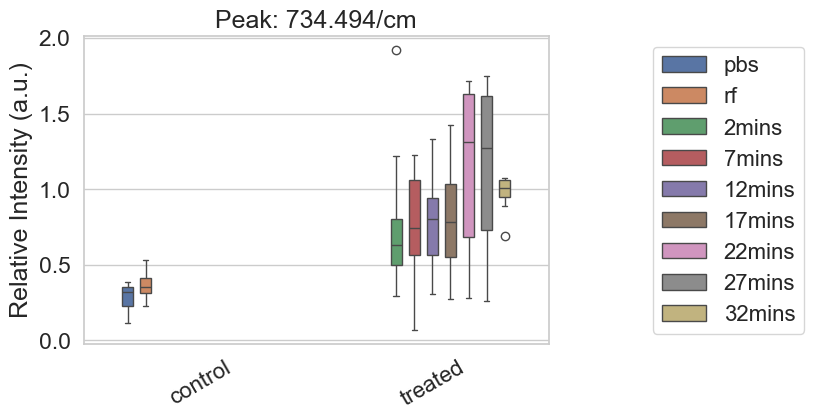

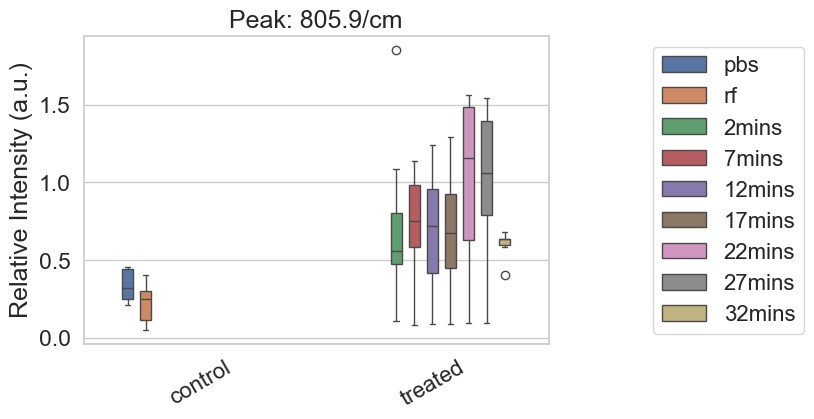

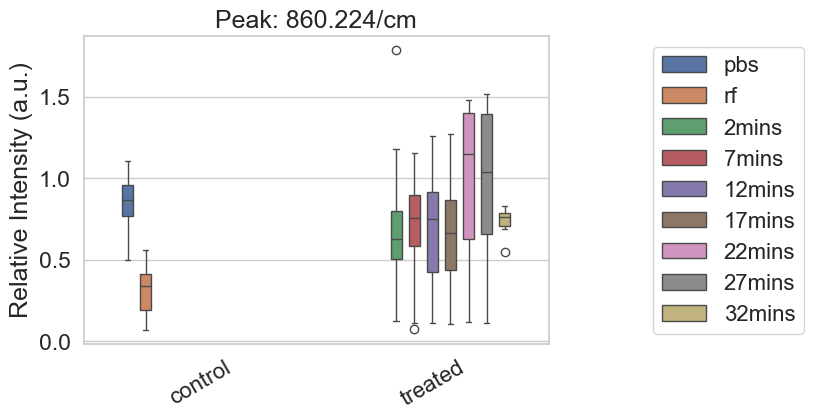

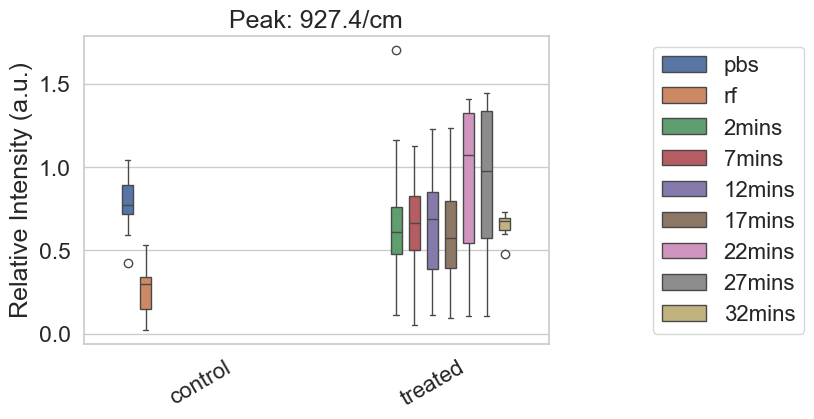

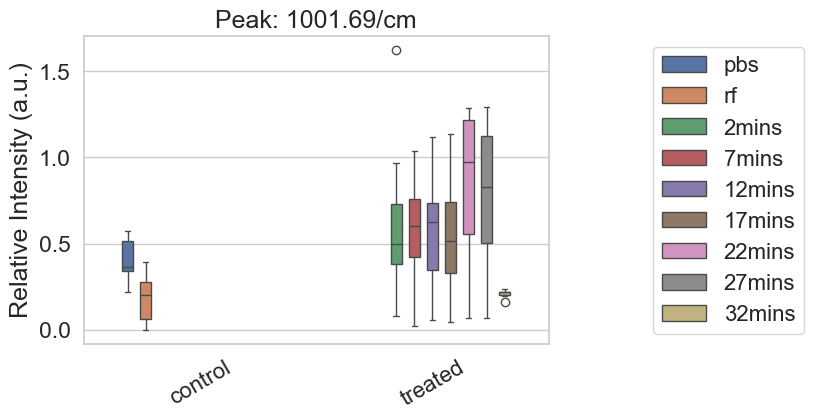

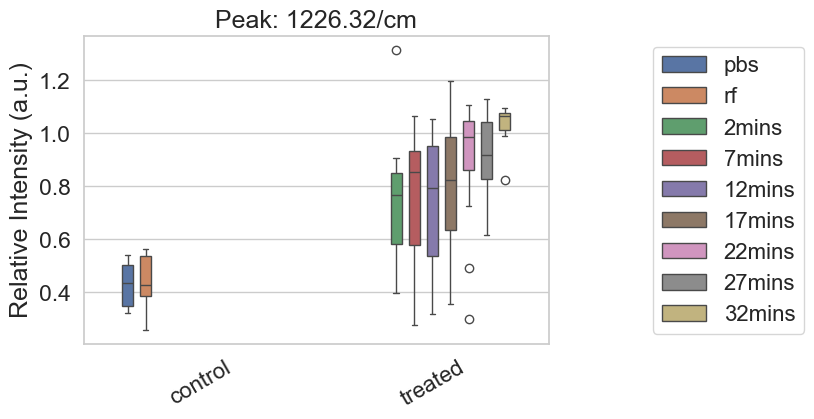

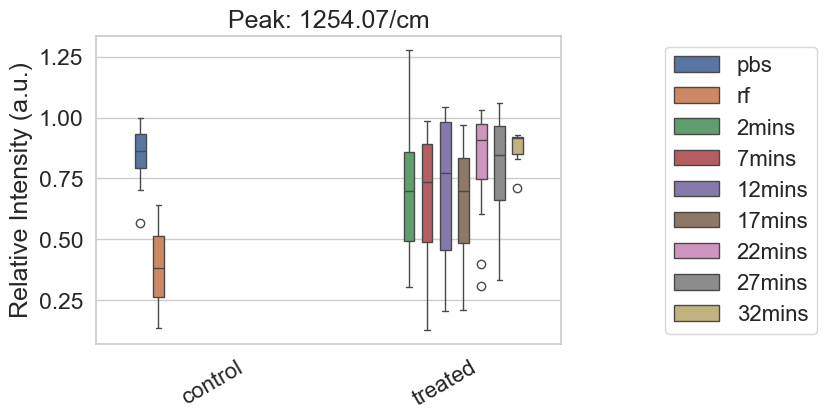

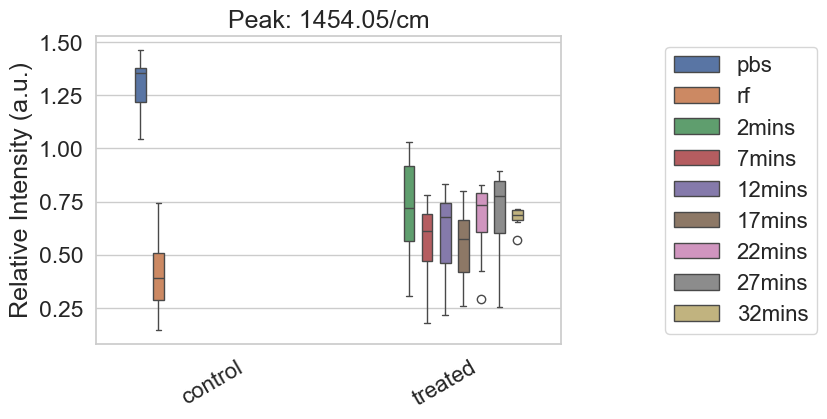

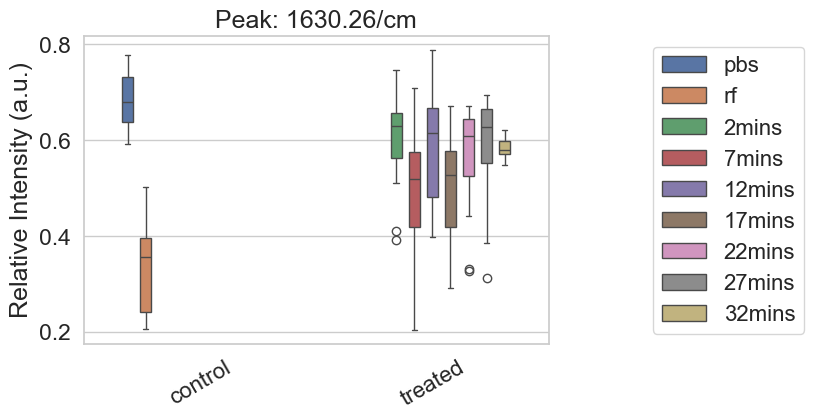

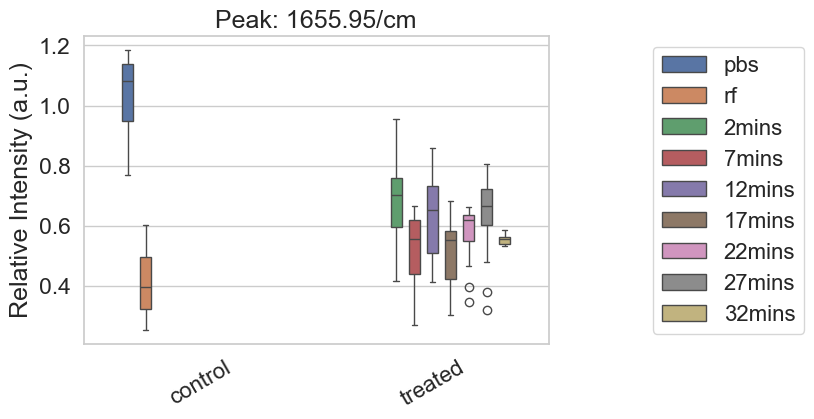

In [ ]:
# Plot to show peak intensity at specified wavelengths between the control and treated samples.

for col in [734.494, 805.9, 860.224, 927.4, 1001.69, 1226.32, 1254.07, 1454.05, 1630.26, 1655.95]:
    plt.figure(figsize = (6, 4));
    sns.boxplot(
        data = df_sam[(df_sam['variable'] == col)], #& (df_sam['value'] > -5)
        #([734.494, 805.9, 860.224, 927.4, 1001.69, 1226.32, 1254.07, 1454.05, 1630.26, 1655.95])],
        x = 'group',
        y = 'value',
        hue = 'Trt',
        hue_order=['pbs','rf', '2mins', '7mins','12mins', '17mins', '22mins','27mins',  '32mins'],
        order=['control', 'treated'],
        #palette={'solid': 'blue', 'empty': 'none'}
        width= .7,
        gap = .4
    );
    #plt.ylim(0, 3)
    plt.xlabel('');
    plt.ylabel('Relative Intensity (a.u.)')
    plt.legend(bbox_to_anchor = (1.2, 1), fontsize = 16);#[], [], 
    plt.xticks(fontsize = 16, rotation = 30);
    plt.title(f'Peak: {col}/cm');

    '''sns.stripplot(
        data = df_sam[df_sam['variable'] == col],#([734.494, 805.9, 860.224, 927.4, 1001.69, 1226.32, 1254.07, 1454.05, 1630.26, 1655.95])],
        x = 'trt',
        y = 'value',
        hue = 'Trt',
        hue_order=['control1','trt2mins', 'trt7mins','trt12mins', 'trt17mins', 'trt22mins','trt27mins',  'trt32mins'],
        marker = 'D',
        jitter = True,
        dodge = True,
        edgecolor = 'gray',
        linewidth = 1
    );'''
    

In [88]:
#Test for equal variances
for v in [734.494, 805.9, 860.224, 927.4, 1001.69, 1226.32, 1254.07, 1454.05, 1630.26, 1655.95]:
    t_stat, p_val = stats.levene(
        df_sam[(df_sam['variable'] == v) & (df_sam['group'] == 'control')]['value'], 
        df_sam[(df_sam['variable'] == v) & (df_sam['group'] == 'treated')]['value'],
        center = 'mean')
    print(f"p-value ({v}): ", p_val)

p-value (734.494):  4.32339513874922e-08
p-value (805.9):  5.689366102992693e-07
p-value (860.224):  0.14048811347808182
p-value (927.4):  0.12897180301019623
p-value (1001.69):  3.3908586595263426e-05
p-value (1226.32):  3.128404637513771e-05
p-value (1254.07):  0.5551248701509996
p-value (1454.05):  3.212235184352112e-14
p-value (1630.26):  8.023211200009732e-05
p-value (1655.95):  1.5687357638671007e-13


In [89]:
#test for comparing means
for v in [734.494, 805.9, 860.224, 927.4, 1001.69, 1226.32, 1254.07, 1454.05, 1630.26, 1655.95]:
    t_stat, p_val = stats.ttest_ind(
        df_sam[(df_sam['variable'] == v) & (df_sam['group'] == 'control')]['value'], 
        df_sam[(df_sam['variable'] == v) & (df_sam['group'] == 'treated')]['value'],
        #equal_var=False
        )
    print(f"p-value ({v}): ", p_val)

p-value (734.494):  6.825490925345886e-10
p-value (805.9):  4.7475913092799186e-09
p-value (860.224):  0.0009950998571506475
p-value (927.4):  0.0007486703759548764
p-value (1001.69):  2.82005550348169e-06
p-value (1226.32):  2.2249897732174737e-15
p-value (1254.07):  0.00033068762694640194
p-value (1454.05):  0.19476571894500247
p-value (1630.26):  0.0003945049240595001
p-value (1655.95):  0.3948142029823888


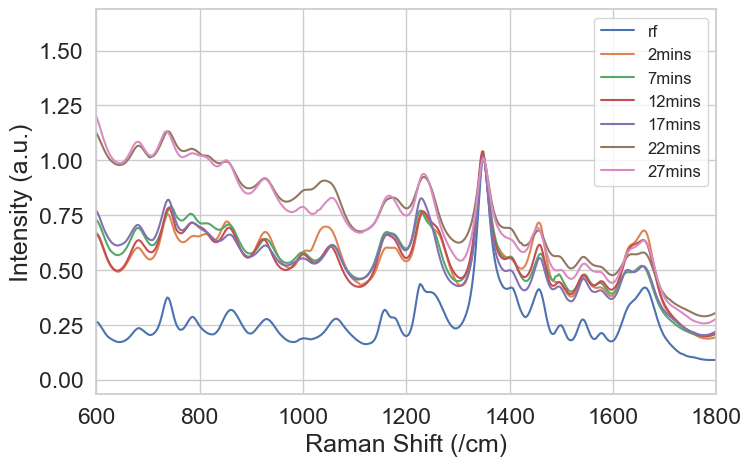

In [ ]:
#plot spectra for each treatment group
plt.figure(figsize = (8, 5))
sns.lineplot(
        data = df_sam[df_sam['Trt'] != 'pbs'], #[df_sam['Trt']!='17mins'], #[df_sam['Trt'].str.contains('NP')], #& (df_sam['pre/post'] == 'post')
        #() & df_sam['Trt'].isin(['Polarized','PolarizedRinsed'])
        #'P_Rinsed', 'NP_Rinsed', 'P_Unrinsed', 'NP_Unrinsed', 'P', 'NP'
        x = 'variable',
        y = 'value',
        hue = 'Trt',
        hue_order=['rf','2mins', '7mins','12mins', '17mins', '22mins','27mins'],#,  '32mins'
        #style='RiboConc',
        #label = 'Xlinked_1%',
        #linestyle = '--',
        #ax = ax1,
        errorbar=None
        );
plt.xlim(600, 1800)
#plt.ylim(0.5, 2500)
#plt.title(' 0.50% RF Treated Samples')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(bbox_to_anchor = (1, 1), fontsize = 12)
#plt.axvline(1350.31, ls = '--', color = 'maroon')
#plt.axvline(1660, ls = '--', color = 'maroon')
#plt.axvline(927, ls = '--', color = 'maroon')

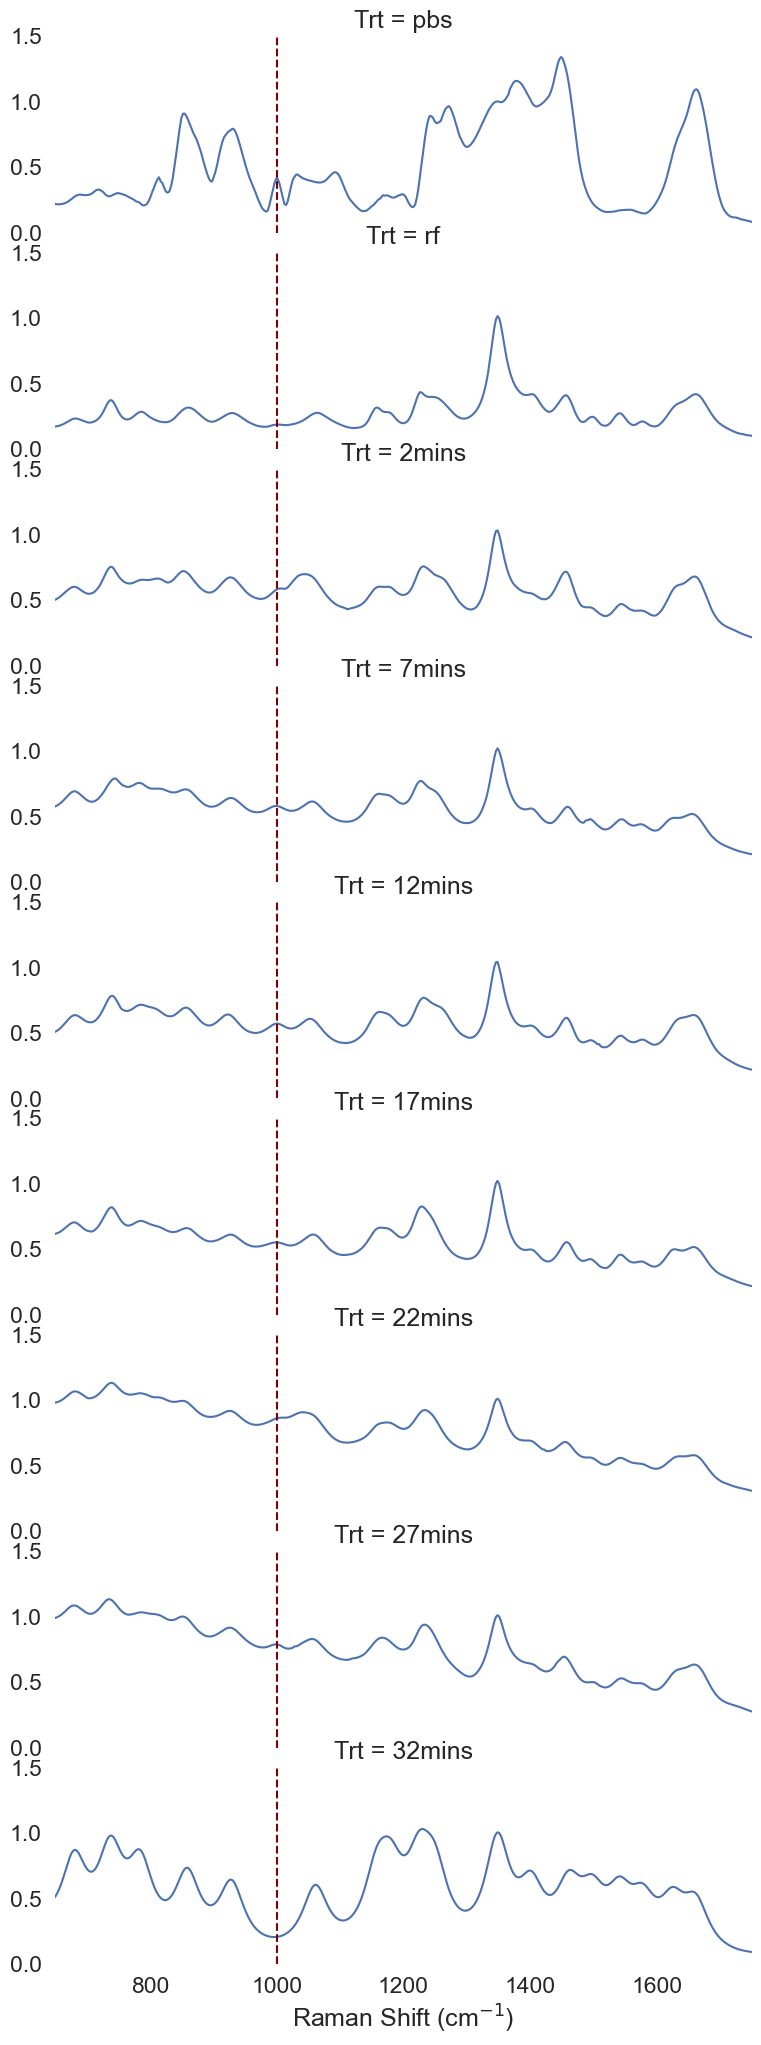

In [ ]:
g = sns.relplot(
    data = df_sam,
    x = 'variable',
    y = 'value',
    kind = 'line',
    row = 'Trt',
    row_order=['pbs','rf','2mins', '7mins','12mins', '17mins', '22mins','27mins', '32mins'],#
    facet_kws=dict(sharex=True, sharey = True),
    height=2.3,
    aspect = 3.5,
    errorbar = None
    );
#g.set(yticklabels = [])
g.set(ylabel='')
#g.set_titles('')
plt.xlim(650, 1750);
plt.ylim(0, 1.5)
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for ax in g.axes.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axvline(1001, color = 'maroon', ls = '--')




## Plot the spectra as a time series
#### Modify dataframe
* Create a sample DataFrame df with columns for Wavelength, Intensity, and Group.
* Define the offset for each group in the group_offsets dictionary.
* Create a new DataFrame df_sam_spectra by copying the original DataFrame.
* Use a loop to add the specified offset to the Intensity values of each group.

In [91]:
# create offsets for each treatment group, exept the pbs
group_offsets = {
    'rf': 1.5,
    '2mins': 2.5,
    '7mins': 3.5,
    '12mins': 4.5,
    '17mins': 5.5,
    '22mins': 6.5,
    '27mins': 7.5,
    '32mins': 8.8
}
#make a copy of the dataframe
df_sam_spectra = df_sam.copy()
# add the defined offset value for each group
for group, offset in group_offsets.items():
    df_sam_spectra.loc[df_sam_spectra['Trt']== group, 'value'] += offset


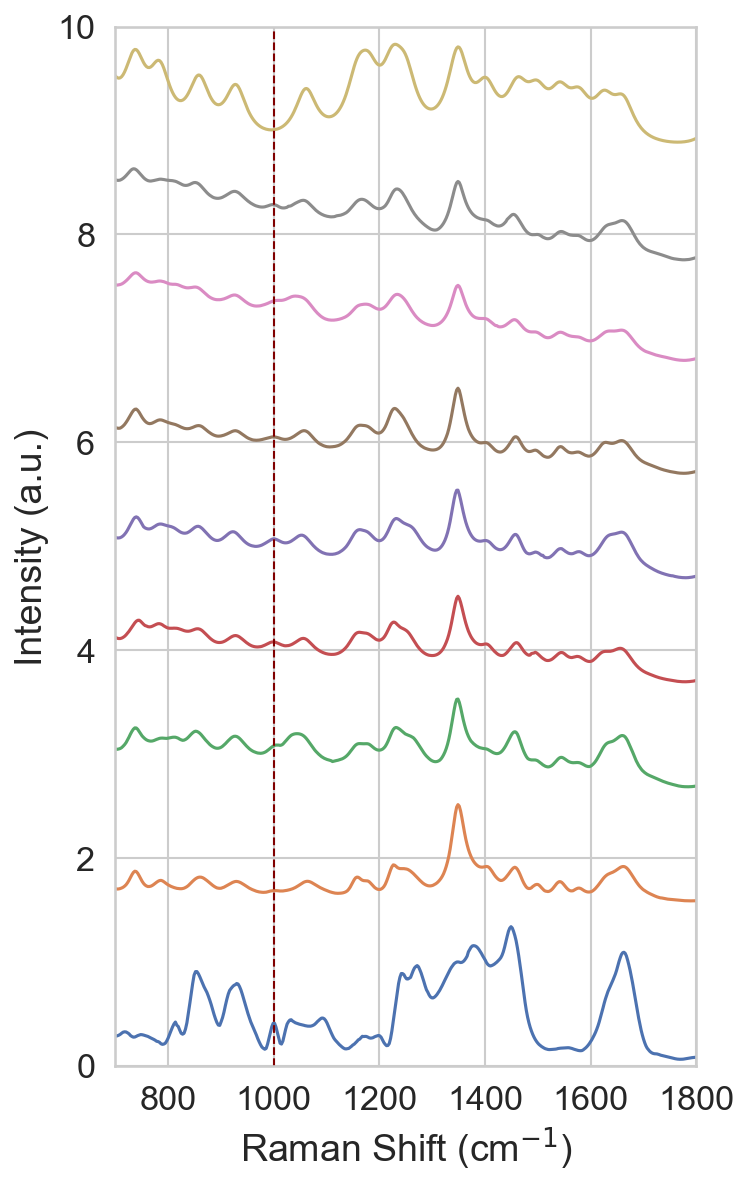

In [186]:
# Create the plot using seaborn
plt.figure(figsize=(5, 9), dpi = 150);
sns.lineplot(
    data=df_sam_spectra, 
    x='variable', 
    y='value', 
    hue='Trt', 
    errorbar=None, 
    #style='group', 
    hue_order=['pbs','rf', '2mins','7mins','12mins', '17mins', '22mins', '27mins',  '32mins'],
    legend = False
);
# Set the x-axis limit
plt.xlim(700, 1800);
plt.ylim(0, 10)

# Add labels and title
plt.xlabel("Raman Shift (cm$^{-1}$)");
plt.ylabel('Intensity (a.u.)');
#lt.title('Stacked Spectral Data with Continuous Y-Axis Ticks and Subgroups')
#plt.legend('');
plt.xticks([800, 1000, 1200, 1400, 1600, 1800]);
plt.axvline(1001, color = 'maroon', ls = '--', lw = 1)

** Deep dive into the differences between peaks at specified wavelengths, to also view shifts in the peaks.

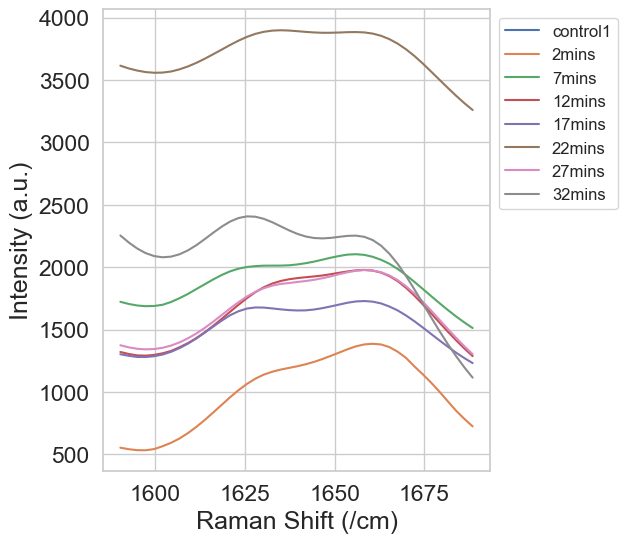

In [13]:
plt.figure(figsize = (5, 6))
sns.lineplot(
        data = df_sam[df_sam['variable'].between(1590, 1690)], #[df_sam[''].isin(['32mins', 'control']) == False], #[df_sam[''].str.contains('NP')], #& (df_sam['pre/post'] == 'post')
        #() & df_sam[''].isin(['Polarized','PolarizedRinsed'])
        #'P_Rinsed', 'NP_Rinsed', 'P_Unrinsed', 'NP_Unrinsed', 'P', 'NP'
        x = 'variable',
        y = 'value',
        hue = 'Trt',
        hue_order=['control1','2mins', '7mins','12mins', '17mins', '22mins','27mins',  '32mins'],#
        #style='RiboConc',
        #label = 'Xlinked_1%',
        #linestyle = '--',
        #ax = ax1,
        errorbar=None
        );
#plt.xlim(1600, 1700)
#plt.ylim(0.5, 2500)
#plt.title(' 0.50% RF Treated Samples')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(bbox_to_anchor = (1, 1), fontsize = 12)
#plt.axvline(1630, ls = '--', color = 'maroon')
#plt.axvline(1660, ls = '--', color = 'maroon')
#plt.axvline(927, ls = '--', color = 'maroon')

## Calculate and plot the difference between the Control and Treated Samples

In [ ]:
#exclude the Control (PBS) group
dtn_mean = dt_norm[dt_norm['Trt'] != 'pbs'].groupby(['group']).mean(numeric_only=True)#.drop(['spectra_num'], axis=1)
dtn_mean.head()

114.269   117.336     120.4   123.463   126.525   129.584  132.643  \
group                                                                          
control  0.821608  0.750372  0.705102  0.679947  0.663395  0.653354  0.64712   
treated  1.052052  1.019634  0.995709  0.983231  0.977125  0.979337  0.98469   

            135.7   138.756    141.81  ...   2580.58   2582.49    2584.4  \
group                                  ...                                 
control  0.642302  0.636415  0.629315  ...  0.017217  0.017404  0.017555   
treated  0.987453  0.989931  0.990873  ...  0.037081  0.037117  0.037084   

          2586.31   2588.22   2590.12   2592.03   2593.93   2595.84   2597.74  
group                                                                          
control  0.017659  0.017724  0.017747  0.017645  0.017480  0.017212  0.016927  
treated  0.037086  0.037034  0.036912  0.036759  0.036487  0.036150  0.035753  

[2 rows x 1024 columns]

In [ ]:
#calculate difference
dtn_diff = dtn_mean.iloc[0]-dtn_mean.iloc[1]
dtn_diff = dtn_diff.reset_index().rename({0: 'diff'}, axis=1)
#combine the group means and mean difference into one table in long form.
df_mean_diff = pd.concat([dtn_diff, dtn_mean.T.reset_index().iloc[:, 1:]], axis=1)
df_md = df_mean_diff.melt(['index'])

In [147]:
# create offsets for each treatment group, exept the pbs
group_offsets = {
    'treated': 0,
    'control': .8,
}
#make a copy of the dataframe
df_md_spectra = df_md.copy()
# add the defined offset value for each group
for group, offset in group_offsets.items():
    df_md_spectra.loc[df_md_spectra['variable']== group, 'value'] += offset

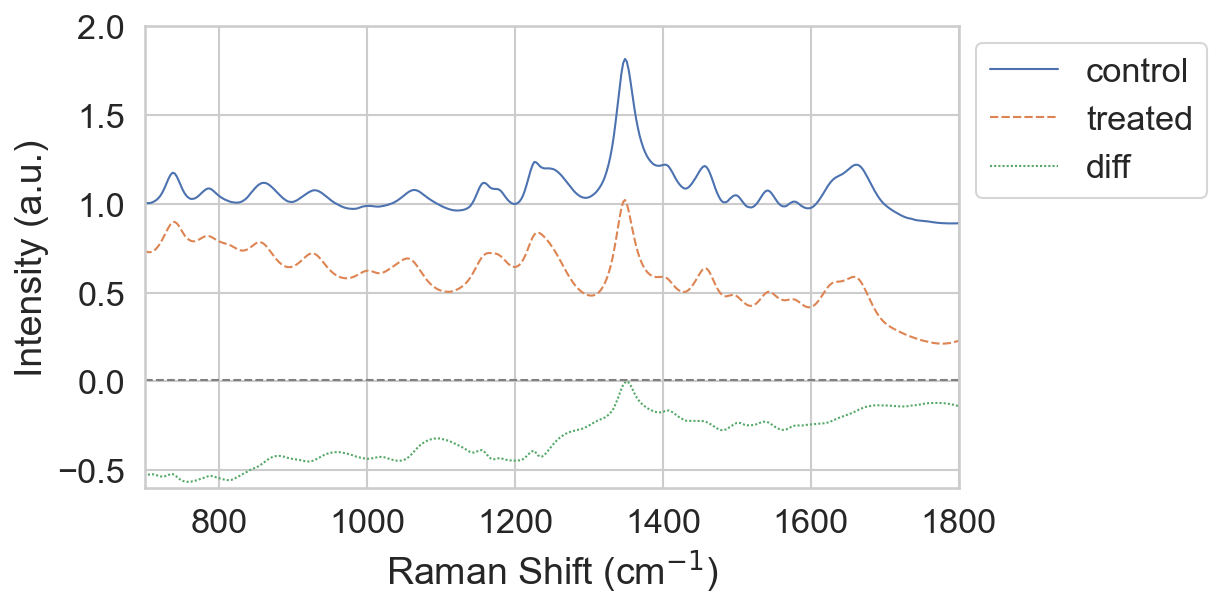

In [173]:
# Create the plot using seaborn
plt.figure(figsize=(7, 4), dpi = 150);
sns.lineplot(
    data=df_md_spectra, 
    x=df_md_spectra['index'].astype(float), 
    y='value', 
    hue='variable', 
    errorbar=None, 
    style='variable', 
    style_order= ['control','treated','diff'],
    hue_order=['control','treated','diff'],
    linewidth = 1
    #legend = False
);
# Set the x-axis limit
plt.xlim(700, 1800);
plt.ylim(-.6, 2)

# Add labels and title
plt.xlabel("Raman Shift (cm$^{-1}$)");
plt.ylabel('Intensity (a.u.)');
#lt.title('Stacked Spectral Data with Continuous Y-Axis Ticks and Subgroups')
plt.legend(bbox_to_anchor = (1,1));
plt.xticks([800, 1000, 1200, 1400, 1600, 1800]);
plt.axhline(0.01, ls = '--', color = 'gray', lw = 1)

### Explore ratios between peaks of interest

In [9]:
df_sam[df_sam['variable'].between(1600, 1700)]['variable'].unique()

array([1602.1 , 1604.45, 1606.81, 1609.16, 1611.51, 1613.85, 1616.2 ,
       1618.55, 1620.89, 1623.24, 1625.58, 1627.92, 1630.26, 1632.61,
       1634.94, 1637.28, 1639.62, 1641.95, 1644.29, 1646.62, 1648.95,
       1651.29, 1653.62, 1655.95, 1658.27, 1660.6 , 1662.93, 1665.25,
       1667.58, 1669.9 , 1672.22, 1674.54, 1676.86, 1679.18, 1681.5 ,
       1683.81, 1686.13, 1688.44, 1690.76, 1693.07, 1695.38, 1697.69,
       1700.  ])

In [ ]:
# Calculate peaks ratios for specified peaks
amide1ratio = pd.concat([dt_norm[dt_norm['Trt'] != 'pbs'].iloc[:, :4].reset_index(), 
                         pd.DataFrame(dt_norm[dt_norm['Trt'] != 'pbs']['1256.59']/dt_norm[dt_norm['Trt'] != 'pbs']['1662.93'], columns = ['ratio']).reset_index()], axis=1)
#amide1ratio.rename({'0': 'ratio'}, inplace=True)
amide1ratio#.head()

index sample RiboConc     Trt    group  index     ratio
0        9  0.5rf  treated  12mins  treated      9  1.241212
1       10  0.5rf  treated  12mins  treated     10  1.340363
2       11  0.5rf  treated  12mins  treated     11  1.248475
3       12  0.5rf  treated  12mins  treated     12  1.298029
4       13  0.5rf  treated  12mins  treated     13  1.217986
..     ...    ...      ...     ...      ...    ...       ...
125     87  0.5rf  control      rf  control     87  0.903412
126     88  0.5rf  control      rf  control     88  0.708072
127     89  0.5rf  control      rf  control     89  0.537740
128     90  0.5rf  control      rf  control     90  0.956651
129     91  0.5rf  control      rf  control     91  0.468830

[130 rows x 7 columns]

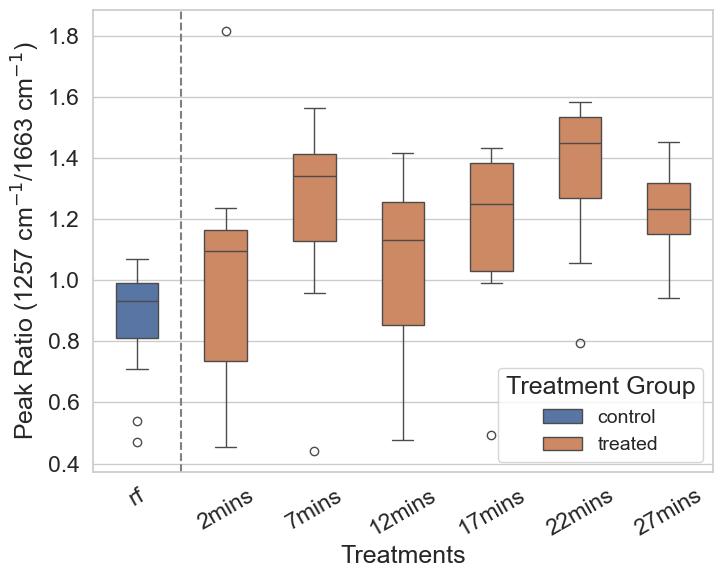

In [155]:
plt.figure(figsize = (8, 6));
sns.boxplot(
    x = 'Trt',
    y = 'ratio',
    hue = 'group',
    data = amide1ratio,
    order=['rf','2mins', '7mins','12mins', '17mins', '22mins','27mins'],#,  '32mins'],
    width=.5,
    gap = .04,
    hue_order = ['control', 'treated'],
    #palette='pastel'
    )
plt.xticks(rotation = 30);
plt.xlabel('Treatments')
plt.axvline(.5, ls = '--', color = 'gray')
plt.ylabel('Peak Ratio (1257 cm$^{-1}$/1663 cm$^{-1}$)')
plt.legend(title = 'Treatment Group', fontsize = 14)
#plt.ylim(0.8, 1.75)

In [156]:
tukey = pairwise_tukeyhsd(endog=amide1ratio['ratio'],
                          groups=amide1ratio['group'],
                          alpha=0.05)

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1  group2 meandiff p-adj lower  upper  reject
---------------------------------------------------
control treated   0.3347   0.0 0.2005 0.4689   True
---------------------------------------------------


In [157]:
t_stat, p_val = stats.ttest_ind(
        amide1ratio[(amide1ratio['group'] == 'control')]['ratio'], 
        amide1ratio[(amide1ratio['group'] == 'treated')]['ratio'],
        #equal_var=False
        )
print(f"p-ratio ({v}): ", p_val)

p-ratio (1655.95):  2.462341947679189e-06


In [164]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


x = MinMaxScaler().fit_transform(dt_norm.iloc[:, 207:607])#dt_norm.iloc[:, 207:607]#
y = dt_norm[dt_norm['Trt'] != 'control'].iloc[:, :4]

pca = PCA(n_components=5)
pc = pca.fit_transform(x)
pc_df = pd.concat([y, pd.DataFrame(pc, columns = [f'PC{x}' for x in np.arange(1, 6)])], axis=1)


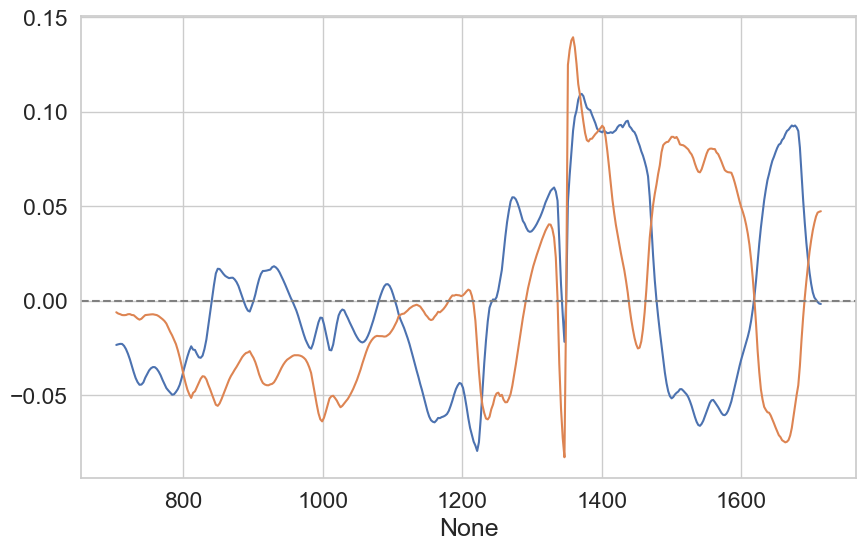

In [165]:
plt.figure(figsize = (10, 6))
sns.lineplot(y = pca.components_[1],
         x = dff.iloc[:, 207:607].columns.astype(float))
sns.lineplot(y = pca.components_[3],
         x = dff.iloc[:, 207:607].columns.astype(float))
plt.axhline(0, color = 'gray', ls = '--')

Text(0, 0.5, 'Variance Explained')

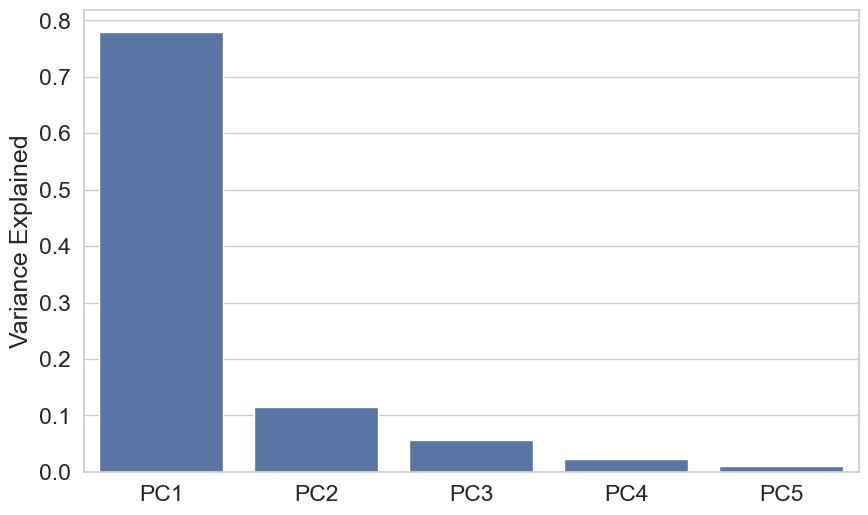

In [166]:
plt.figure(figsize = (10, 6))
sns.barplot(x = [f'PC{x}' for x in np.arange(1, 6)],
            y = pca.explained_variance_ratio_)
plt.ylabel('Variance Explained')

Text(0.5, 1.0, 'PCA Analysis of Cross Linked Mice Tail Tendon (MTT)')

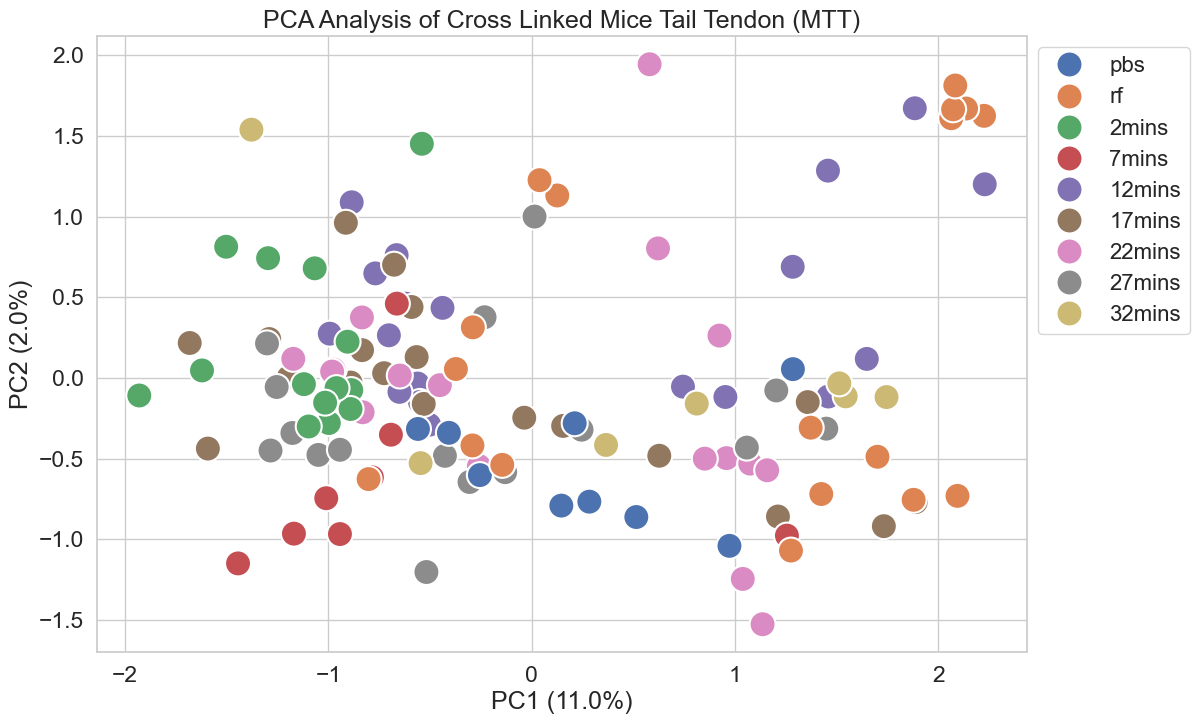

In [168]:
plt.figure(figsize = (12, 8))
sns.scatterplot(
    x = 'PC3',
    y = 'PC4',
    data = pc_df,#.groupby('Trt').mean(numeric_only=True)#[pc_df['PC1'] < 50],#pc_df[pc_df['PC1'] < 50].groupby(['RiboConc', 'Trt']).median().reset_index(), #
    hue = 'Trt',
    hue_order=['pbs', 'rf', '2mins', '7mins','12mins', '17mins', '22mins', '27mins',
        '32mins'],
    #style = 'Trt',
    s = 350
)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[1].round(2) * 100}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[3].round(2) * 100}%)')
plt.legend(bbox_to_anchor = (1, 1), fontsize = 16)
plt.title('PCA Analysis of Cross Linked Mice Tail Tendon (MTT)')

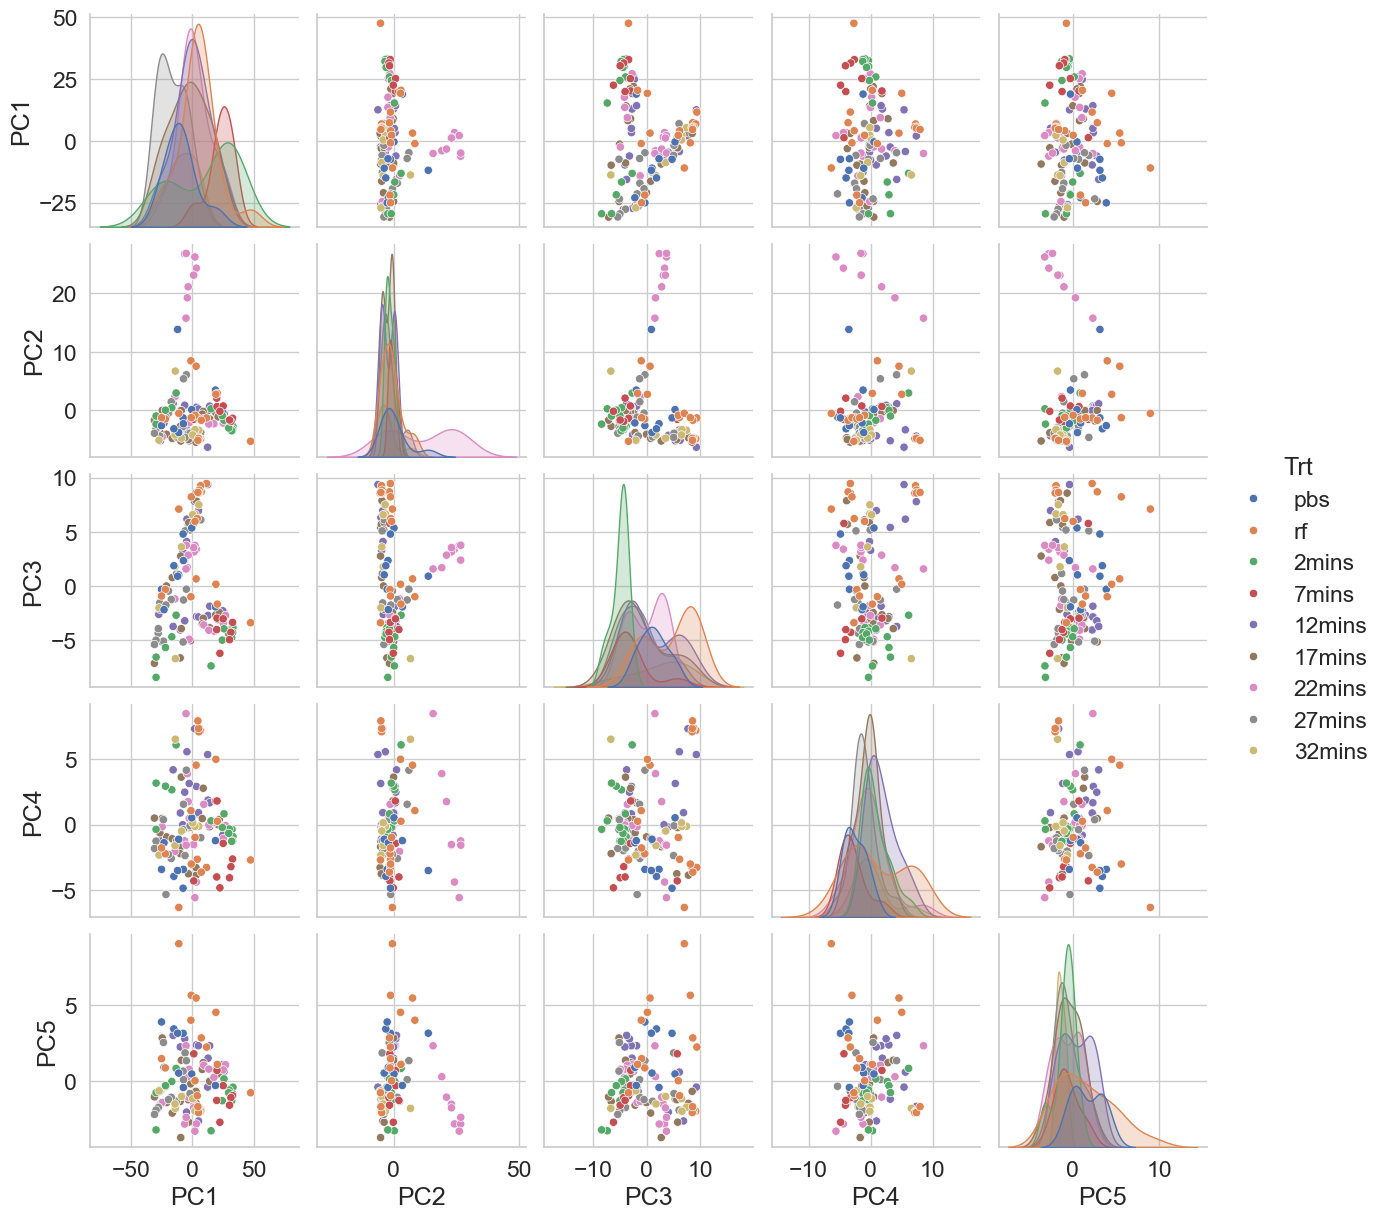

In [ ]:
sns.pairplot(pc_df,
             hue = 'Trt',
    hue_order=['pbs', 'rf', '2mins', '7mins','12mins', '17mins', '22mins', '27mins',
        '32mins']
        );

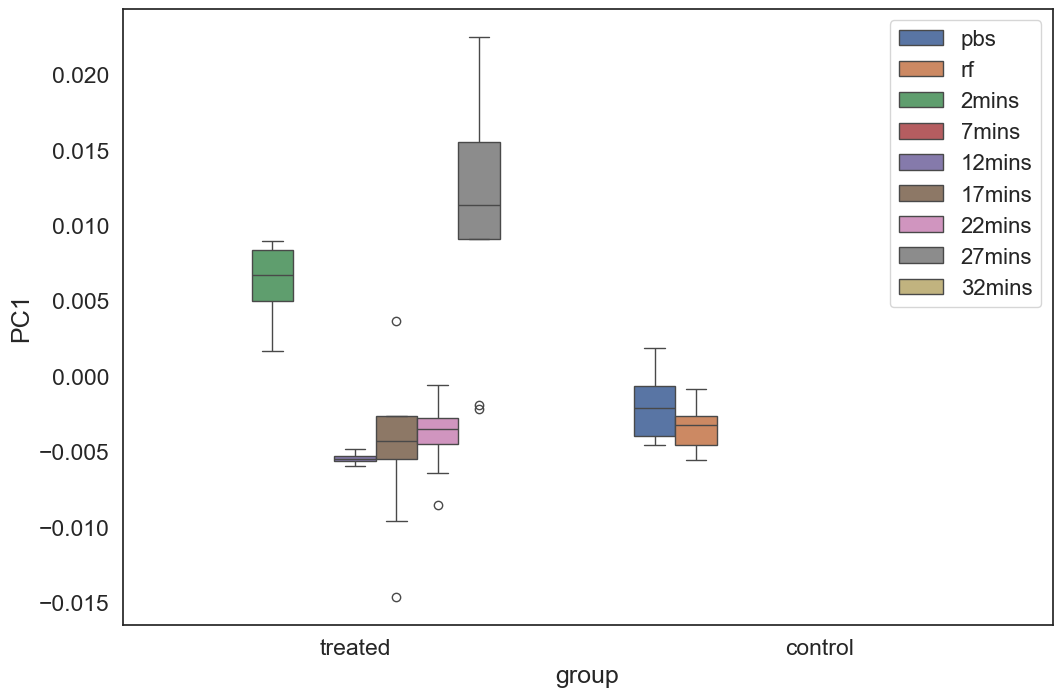

In [307]:
plt.figure(figsize = (12, 8))
sns.boxplot(
    x = 'group',
    y = 'PC1',
    hue = 'Trt',
    hue_order=['pbs', 'rf', '2mins', '7mins','12mins', '17mins', '22mins', '27mins', '32mins'],
    data = pc_df#[pc_df['PC3'] >-10]#[(pc_df['PC1'] < 10) & (df_sam['Trt'].isin(['P_Rinsed', 'P', 'P_Unrinsed']))]
)
#NP_Rinsed, , 'NP_Unrinsed'
plt.legend(bbox_to_anchor = (1, 1), fontsize = 16)

In [99]:
pc_df.Trt.unique()

array(['control1', 'trt12mins', 'trt17mins', 'trt22mins', 'trt27mins',
       'trt2mins', 'trt32mins', 'trt7mins', nan], dtype=object)

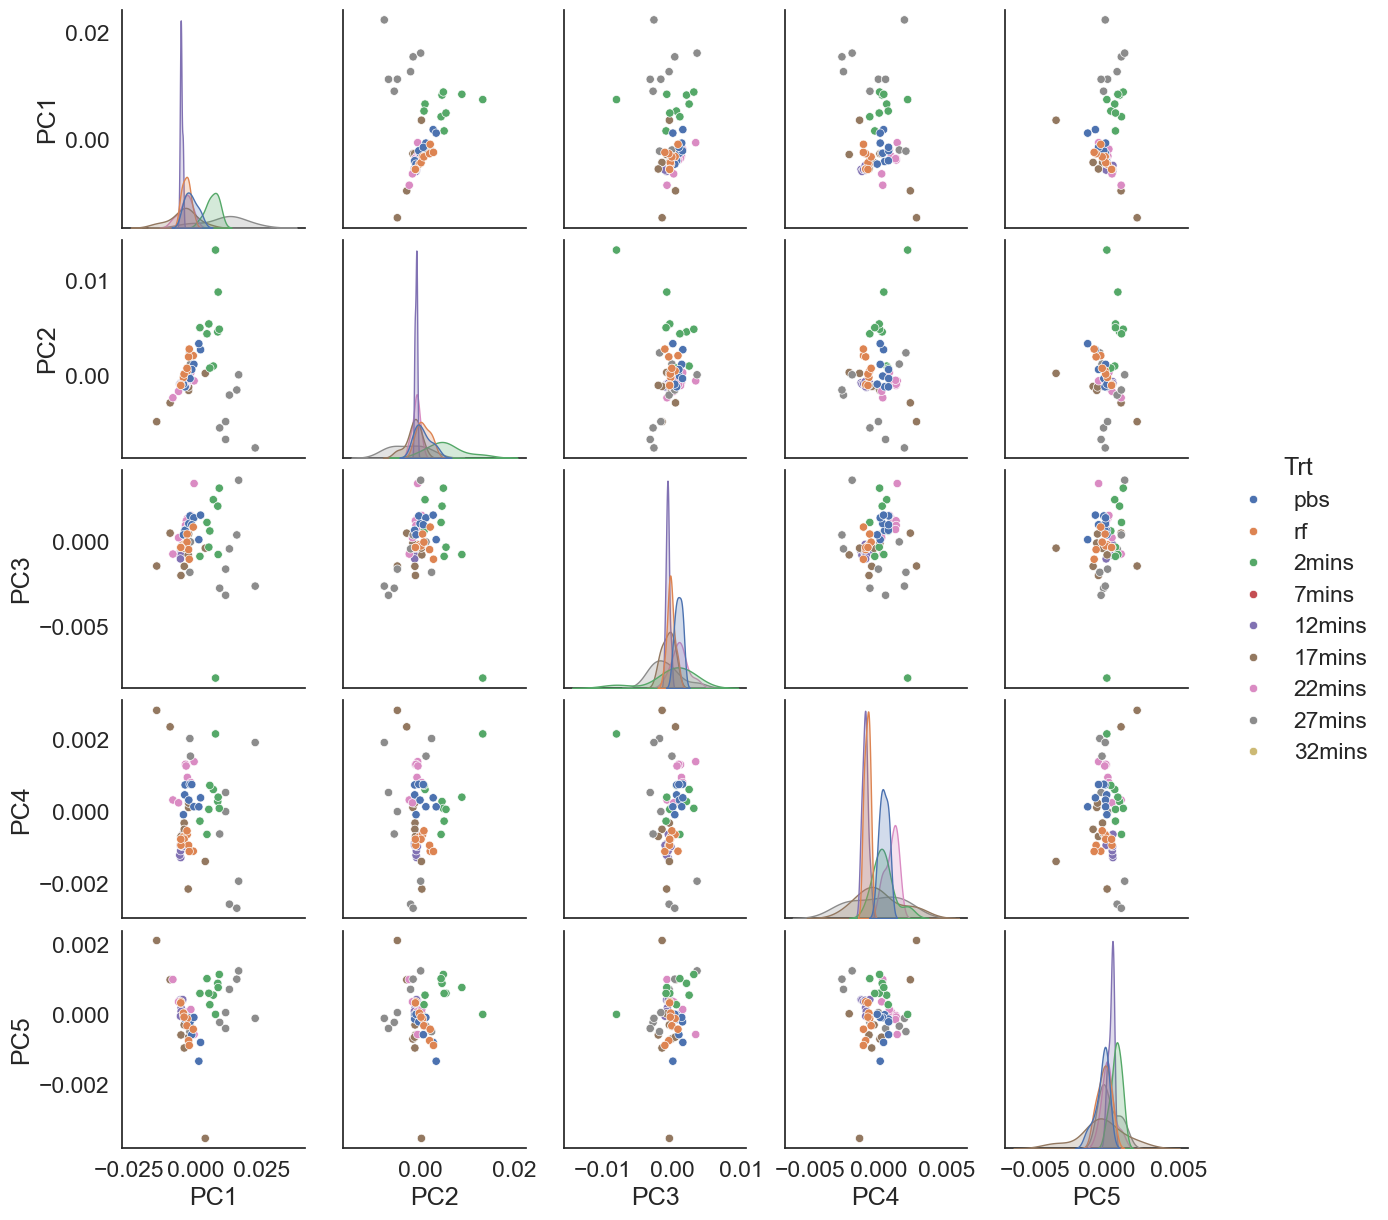

In [308]:
sns.pairplot(
    data = pc_df, #.drop, #('spectra_num', axis=1),
    hue = 'Trt',
    hue_order=['pbs', 'rf', '2mins', '7mins','12mins', '17mins', '22mins', '27mins',
        '32mins']
    #style = 'Trt',
    #s = 150
             )

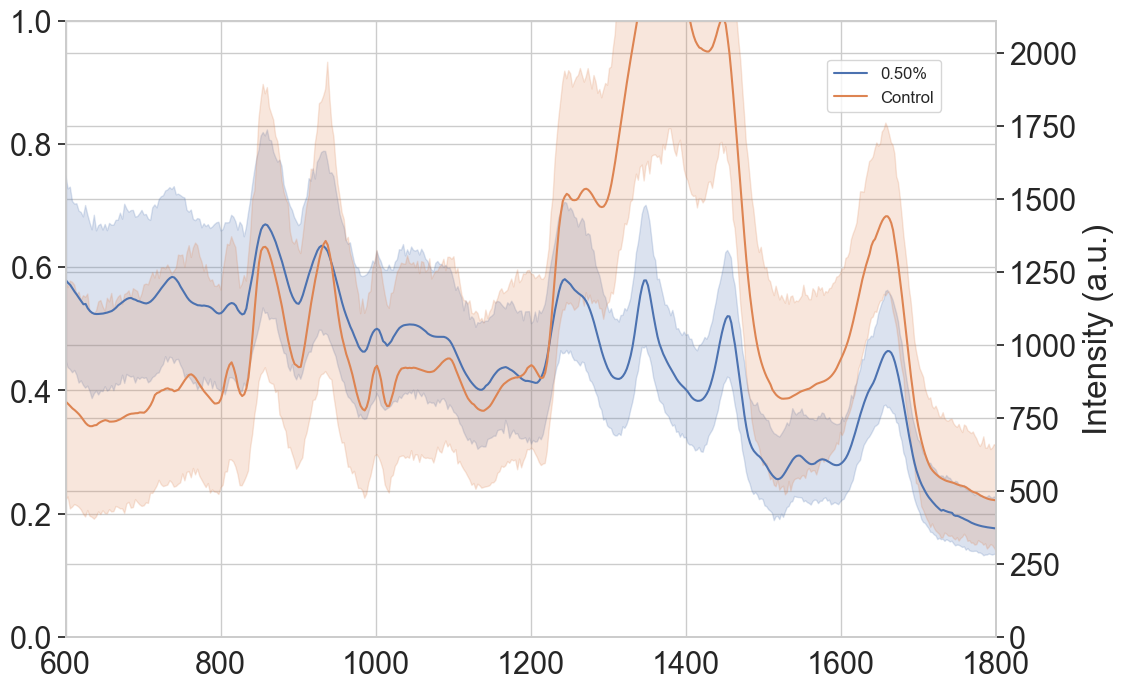

In [67]:
fig, ax1 = plt.subplots(figsize = (12, 8))
'''sns.lineplot(
        data = df_sam[(df_sam['RiboConc'] == 'Ribo1')& (df_sam['pre/post'] == 'post')], #& (df_sam['pre/post'] == 'post')
        x = 'variable',
        y = 'value',
        #hue = 'RiboConc',
        #hue_order=['pre','post1','post2', 'post3']
        #style='Trt',
        label = 'Xlinked_1%',
        linestyle = '--',
        ax = ax1
        );
#plt.title('Micetail_Xlink')#_Normalized (1350/cm)')
#plt.ylim(0, 3000)
plt.xlim(600, 1800)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12)'''

ax2 = ax1.twinx()
sns.lineplot(
        data = df_sam,#[(df_sam['RiboConc'].isin(['1%', 'PBS']))], #& (df_sam['pre/post'] == 'post')
        x = 'variable',
        y = 'value',
        hue = 'RiboConc',
        #hue_order=['pre','post1','post2', 'post3']
        #style='Trt',
        #label = 'Riboflavin_1%',
        color = 'green',
        ax = ax2
        );
#plt.title('Micetail_0.1% RF')#_Normalized (1350/cm)')
ax2.set_ylim(0, 2110)
ax2.set_xlim(600, 1800)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12, bbox_to_anchor = (.95, .95))

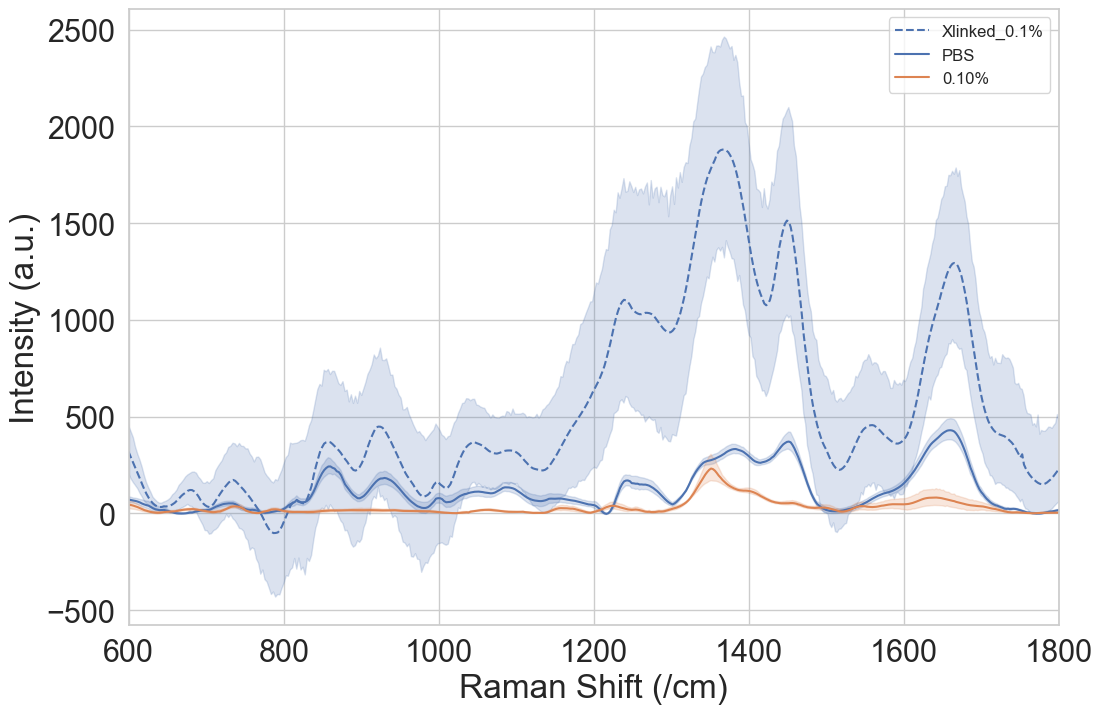

In [253]:
plt.figure(figsize = (12, 8))
sns.lineplot(
        data = df_sam[(df_sam['RiboConc'] == 'Ribo0.1')& (df_sam['pre/post'] == 'post')], #& (df_sam['pre/post'] == 'post')
        x = 'variable',
        y = 'value',
        #hue = 'RiboConc',
        #hue_order=['pre','post1','post2', 'post3']
        #style='Trt',
        label = 'Xlinked_0.1%',
        linestyle = '--'
        );
#plt.title('Micetail_Xlink')#_Normalized (1350/cm)')
#plt.ylim(0, 3000)
plt.xlim(600, 1800)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12)

sns.lineplot(
        data = df_sam[(df_sam['RiboConc'].isin(['0.10%', 'PBS']))], #& (df_sam['pre/post'] == 'post')
        x = 'variable',
        y = 'value',
        hue = 'RiboConc',
        #hue_order=['pre','post1','post2', 'post3']
        #style='Trt',
        #label = 'Riboflavin_1%',
        color = 'green'
        );
#plt.title('Micetail_0.1% RF')#_Normalized (1350/cm)')
#plt.ylim(0, 3000)
plt.xlim(600, 1800)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12)

In [ ]:
df_sam[df_sam['sample'] != 'Ribo']['RiboConc'].unique()

array(['PBS', 'Ribo0.1', 'Ribo0.5', 'Ribo1', '0.10%', '0.50%', '1%'],
      dtype=object)

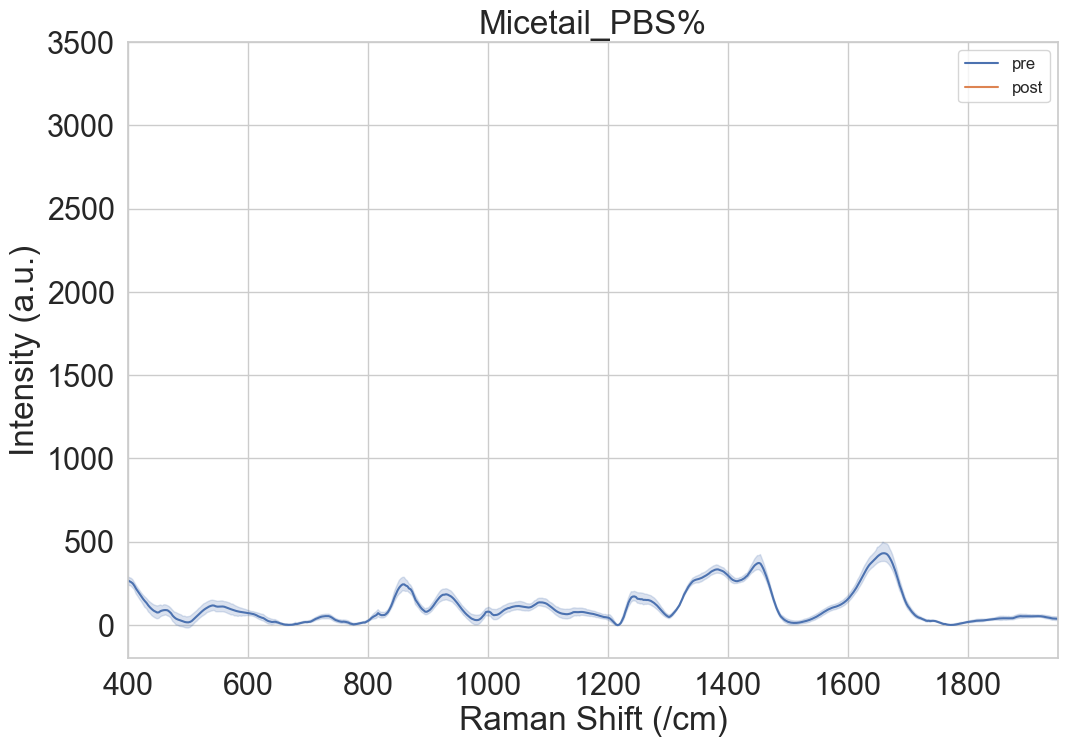

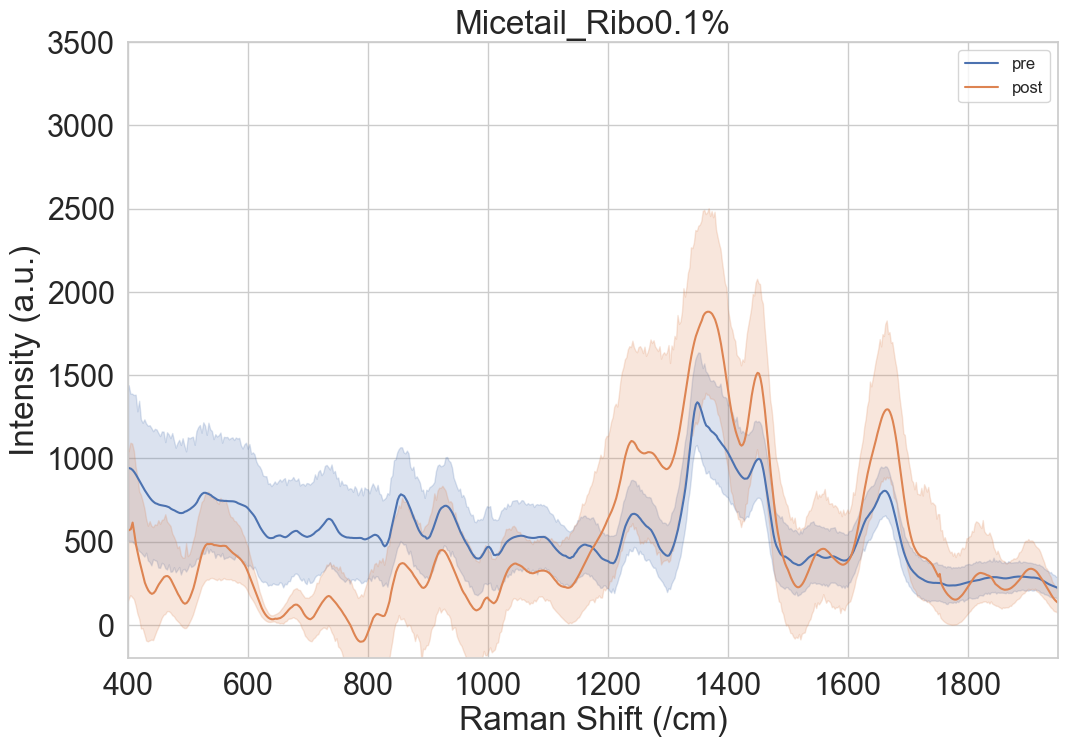

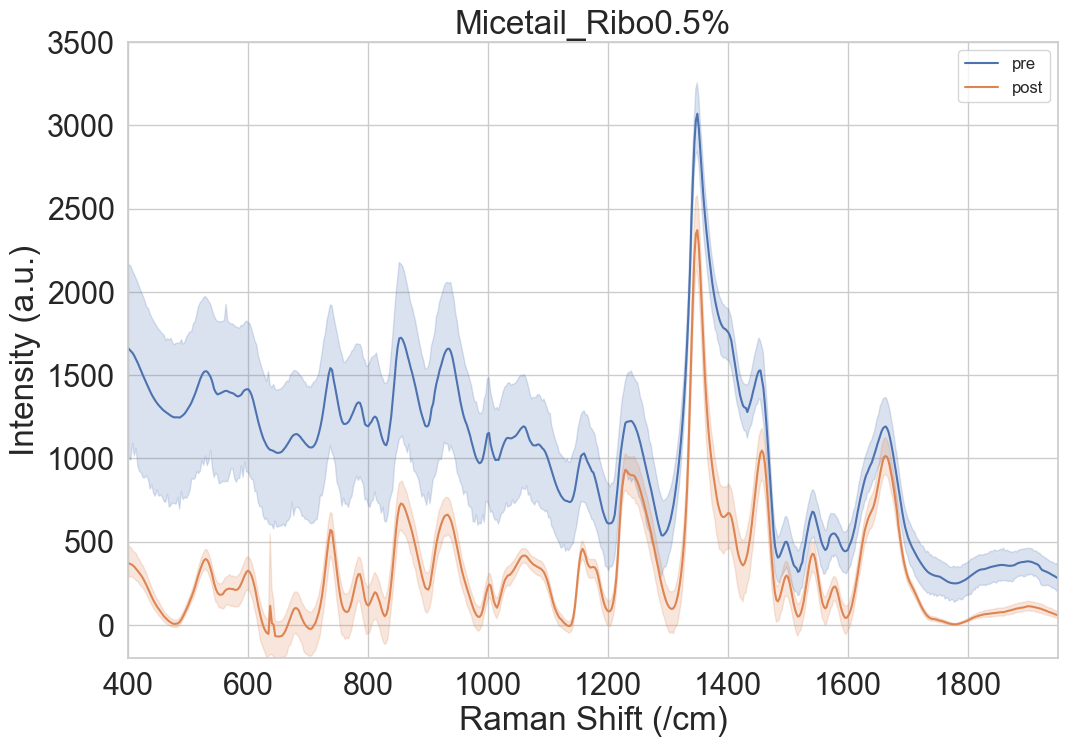

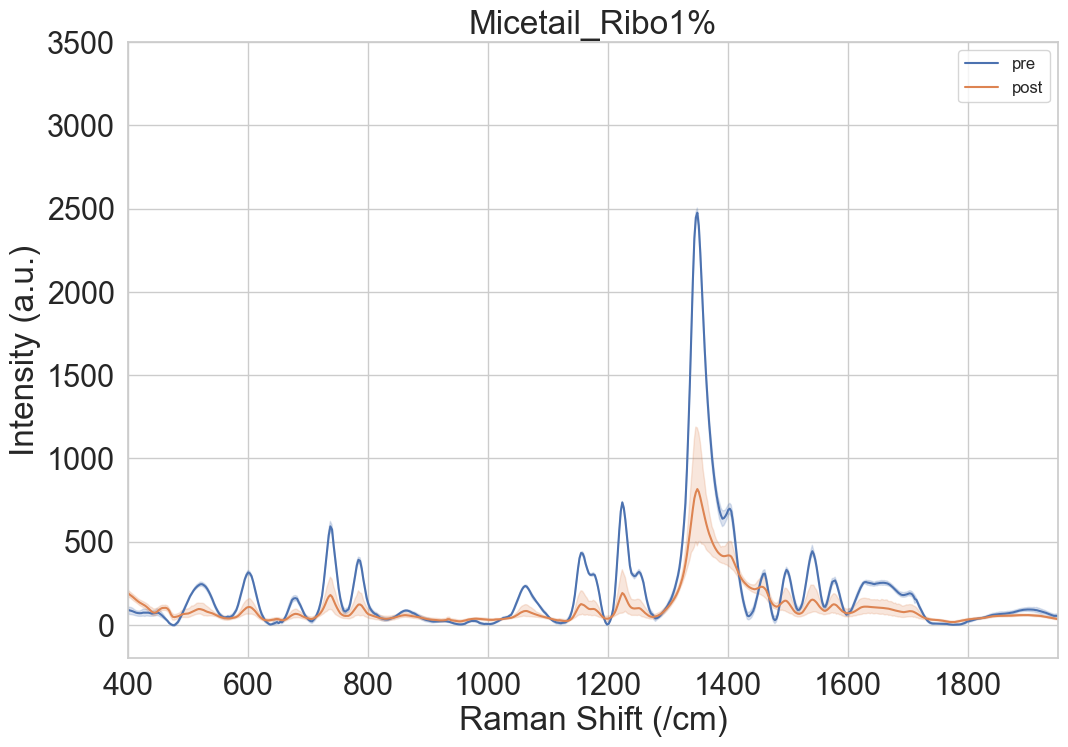

In [158]:
for x in df_sam[df_sam['sample'] == 'MT']['RiboConc'].unique():
    #print(x)
    plt.figure(figsize = (12, 8))
    sns.lineplot(
        data = df_sam[(df_sam['RiboConc'] == x)],
        x = 'variable',
        y = 'value',
        hue = 'pre/post',
        hue_order=['pre','post']#,'post2', 'post3'],
        #style='Trt'
        );
    plt.title(f'Micetail_{x}%')#_Normalized (1350/cm)')
    plt.ylim(-200, 3500)
    plt.xlim(400, 1950)
    plt.ylabel('Intensity (a.u.)')
    plt.xlabel('Raman Shift (/cm)')
    plt.legend(fontsize = 12)

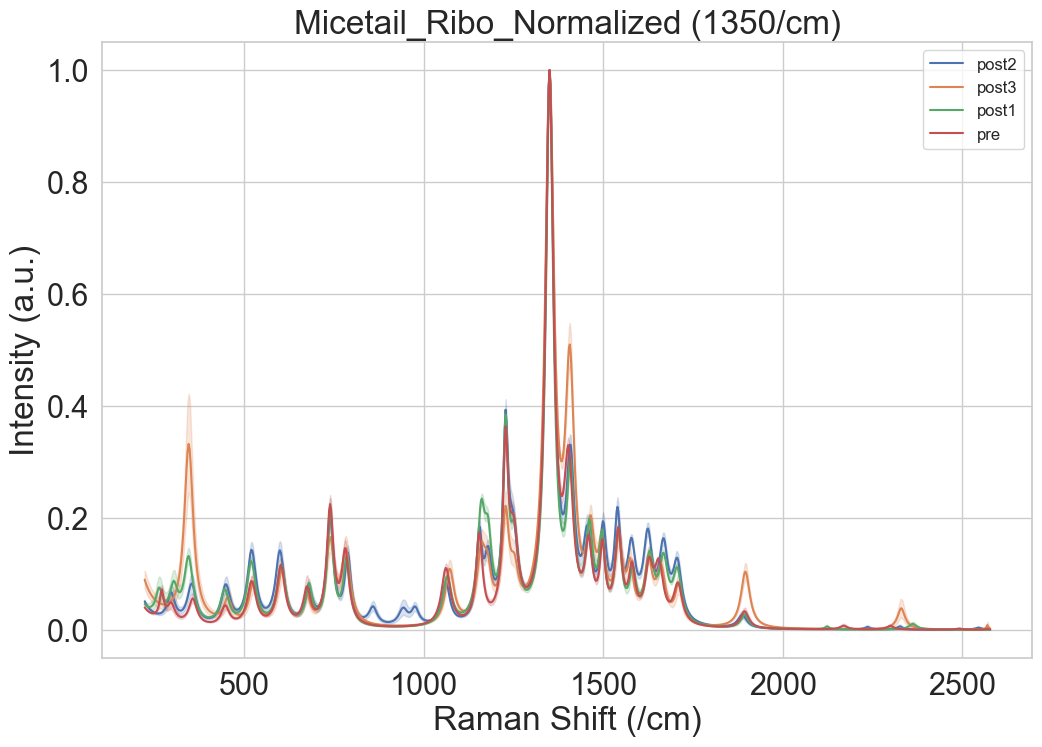

In [108]:
plt.figure(figsize = (12, 8))
sns.lineplot(
    data = df_sam[df_sam['RiboConc'] == 'Ribo0.5'],
    x = 'variable',
    y = 'value',
    hue = 'Trt',
    #style='Trt'
    );
plt.title('Micetail_Ribo_Normalized (1350/cm)')
#plt.ylim(-.01, 0.5)
#plt.xlim(1400, 1500)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12)

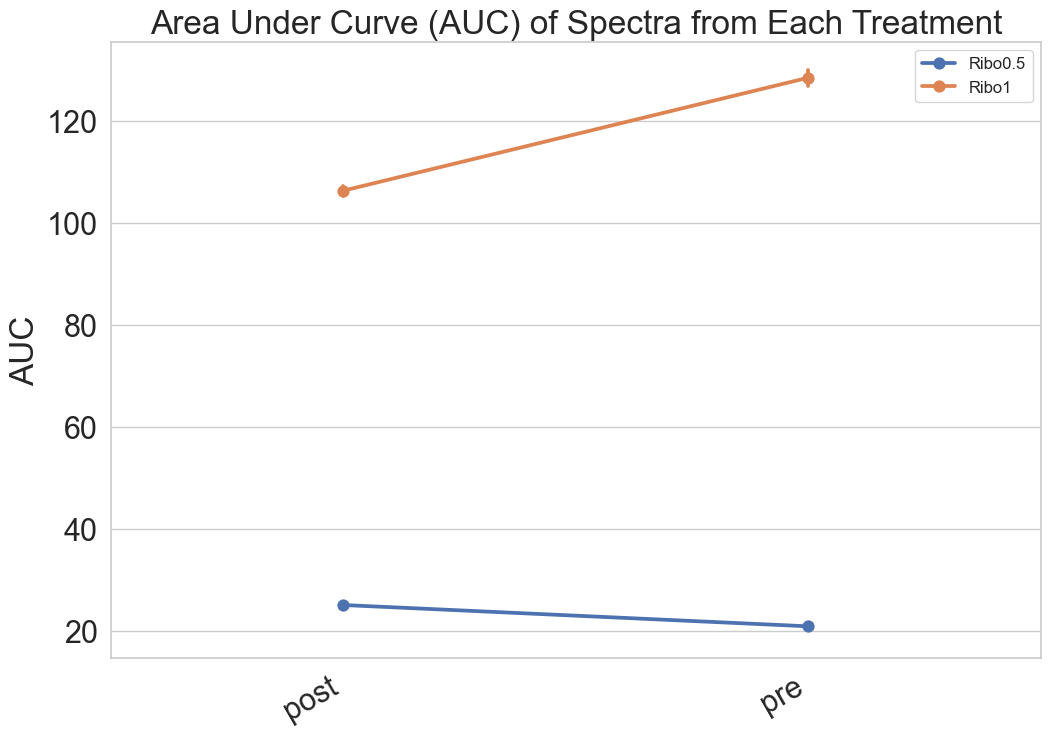

In [7]:
plt.figure(figsize = (12, 8));
sns.pointplot(
    data = df_sam,
    x = 'pre/post',
    y = 'value',
    hue = 'RiboConc',
    #hue_order=['pre','post1','post2', 'post3']
    #order= ['pre','post1','post2', 'post3'],
              );
plt.xticks(rotation = 30, ha = 'right');
plt.xlabel('');
plt.ylabel('AUC')
plt.title('Area Under Curve (AUC) of Spectra from Each Treatment');
plt.legend(fontsize = 12);

In [314]:
dt_norm.sum(axis=1, numeric_only=True)

0     62.373561
1     61.537438
2     66.399192
3     55.872863
4     53.462231
        ...    
83    69.780602
84    78.236479
85    67.476977
86    72.253025
87    76.859718
Length: 88, dtype: float64

In [29]:
dt[['1402.2']]

1402.2
0    61.4520
1    64.4653
2    75.5561
3    85.4148
4    74.8046
..       ...
83  289.6200
84  313.6110
85  307.7490
86  295.3300
87  271.0780

[88 rows x 1 columns]

In [30]:
df_auc = pd.concat([dt.iloc[:, :4], dt[['1402.2']]], axis=1)#dt.sum(axis=1, numeric_only=True)

In [31]:
df_auc#[0]

sample RiboConc    Trt pre/post    1402.2
0      MT  Ribo0.5  post2     post   61.4520
1      MT  Ribo0.5  post2     post   64.4653
2      MT  Ribo0.5  post2     post   75.5561
3      MT  Ribo0.5  post2     post   85.4148
4      MT  Ribo0.5  post2     post   74.8046
..    ...      ...    ...      ...       ...
83     MT    Ribo1    pre      pre  289.6200
84     MT    Ribo1    pre      pre  313.6110
85     MT    Ribo1    pre      pre  307.7490
86     MT    Ribo1    pre      pre  295.3300
87     MT    Ribo1    pre      pre  271.0780

[88 rows x 5 columns]

In [32]:
#Test of Normal Distribution
for x in df_auc['RiboConc'].unique():
    for y in df_auc['Trt'].unique():
        print(x, y)
        stat, p = sst.shapiro(df_auc[(df_auc['RiboConc'] == x) & (df_auc['Trt'] == y)]['1402.2'])
        if p > 0.05:
            print('Distribution not normal')
        else:
            print('Normal Distribution')

Ribo0.5 post2
Distribution not normal
Ribo0.5 post3
Distribution not normal
Ribo0.5 post1
Distribution not normal
Ribo0.5 pre
Distribution not normal
Ribo1 post2
Distribution not normal
Ribo1 post3
Distribution not normal
Ribo1 post1
Distribution not normal
Ribo1 pre
Distribution not normal


In [9]:
#ANOVA to test differences between group means
model = ols('value ~ RiboConc + Trt + RiboConc:Trt', df_sam).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
print(anova_table)

                    sum_sq       df             F        PR(>F)
RiboConc      1.662463e+08      1.0  32005.337771  0.000000e+00
Trt           1.898583e+06      3.0    121.836910  9.592241e-79
RiboConc:Trt  8.489261e+06      3.0    544.777481  0.000000e+00
Residual      4.474603e+08  86144.0           NaN           NaN


In [33]:
# Across group t-test
tukey_dfs = []
for x in df_auc['RiboConc'].unique():
    tukey = pairwise_tukeyhsd(endog=df_auc[df_auc['RiboConc'] == x]['1402.2'],
                          groups=df_auc[df_auc['RiboConc'] == x]['Trt'],
                          alpha=0.05)
    print(x)
    print(tukey)
    #print(pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0]))
    print('********************************************')
    tukey_dfs.append(pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0]))

Ribo0.5
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
 post1  post2  -9.1074 0.5529 -27.5326   9.3178  False
 post1  post3  56.7997    0.0  38.3745  75.2249   True
 post1    pre  -1.9311 0.9921 -20.3563  16.4941  False
 post2  post3  65.9071    0.0  47.4819  84.3323   True
 post2    pre   7.1763 0.7249 -11.2489  25.6015  False
 post3    pre -58.7308    0.0  -77.156 -40.3056   True
------------------------------------------------------
********************************************
Ribo1
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 post1  post2 -32.3699 0.7857 -125.0513  60.3115  False
 post1  post3 -44.6226 0.5742 -137.3041  48.0588  False
 post1    pre -23.6201 0.9029 -116.3015  69.0613  False
 post2  post3 -12.2527 0.9845 -104.9342  80.4287  False

In [398]:
tukey_dfs[0]

group1 group2    meandiff   p-adj       lower       upper  reject
0  post1  post2  -1601.3240  0.6067  -5067.6369   1864.9890   False
1  post1  post3  13091.0733  0.0000   9624.7604  16557.3863    True
2  post1    pre   -262.9424  0.9970  -3729.2554   3203.3705   False
3  post2  post3  14692.3973  0.0000  11226.0843  18158.7102    True
4  post2    pre   1338.3815  0.7301  -2127.9314   4804.6945   False
5  post3    pre -13354.0158  0.0000 -16820.3287  -9887.7028    True

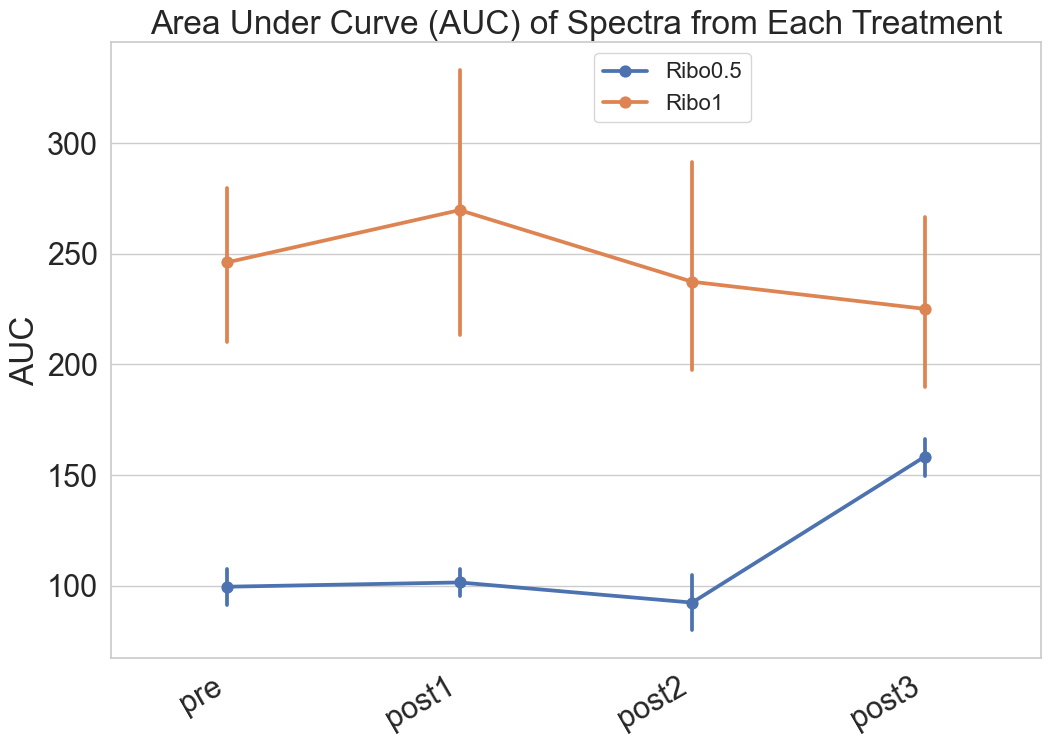

In [34]:
plt.figure(figsize = (12, 8));
sns.pointplot(
    data = df_auc,
    x = 'Trt',
    y = '1402.2',
    hue = 'RiboConc',
    #hue_order=['pre','post1','post2', 'post3']
    order= ['pre','post1','post2', 'post3'],
              );
plt.xticks(rotation = 30, ha = 'right');
plt.xlabel('');
plt.ylabel('AUC')
plt.title('Area Under Curve (AUC) of Spectra from Each Treatment');
plt.legend(fontsize = 16, bbox_to_anchor = (.7, 1));

In [374]:
dfm = dt_norm.groupby(['RiboConc', 'pre/post']).mean(numeric_only=True).reset_index()
dfm

RiboConc pre/post   219.694   222.708   225.721   228.732   231.743  \
0  Ribo0.5     post  0.143181  0.121509  0.102797  0.086361  0.072693   
1  Ribo0.5      pre  0.093481  0.072354  0.055751  0.041378  0.032330   
2    Ribo1     post  0.696855  0.660384  0.625499  0.592905  0.562351   
3    Ribo1      pre  0.704311  0.671063  0.640527  0.612315  0.585241   

    234.751   237.758   240.763  ...   2560.69   2562.61   2564.52   2566.44  \
0  0.061603  0.052288  0.044915  ...  0.004375  0.004380  0.004001  0.003847   
1  0.024496  0.017483  0.012662  ...  0.001982  0.002419  0.002756  0.002375   
2  0.533264  0.505601  0.479531  ...  0.217250  0.218314  0.219204  0.220020   
3  0.559023  0.533998  0.509437  ...  0.357509  0.358943  0.360377  0.361634   

    2568.36   2570.27   2572.18    2574.1   2576.01   2577.92  
0  0.003668  0.003405  0.002286  0.001167  0.000494 -0.000307  
1  0.002244  0.001877  0.001588  0.001378  0.001654  0.000784  
2  0.220827  0.221568  0.222583  0.223451  0.224478  0.225148  
3  0.362691  0.364004  0.365464  0.367117  0.368726  0.369176  

[4 rows x 981 columns]

In [375]:
drt = pd.concat([pd.DataFrame(dfm[dfm['RiboConc'].str.contains('0.5')].iloc[0, 3:] - dfm[dfm['RiboConc'].str.contains('0.5')].iloc[1, 3:]).T, 
           pd.DataFrame(dfm[dfm['RiboConc'].str.contains('1')].iloc[0, 3:] - dfm[dfm['RiboConc'].str.contains('1')].iloc[1, 3:]).T])#.insert(0, 'RiboConc', ['Ribo0.5', 'Ribo1'])

In [376]:
drt.insert(0, 'RiboConc', ['Ribo0.5', 'Ribo1'])

In [377]:
drt = drt.melt(id_vars = 'RiboConc')
drt[['variable', 'value']] = drt[['variable', 'value']].astype(float)
drt

RiboConc  variable     value
0     Ribo0.5   222.708  0.049155
1       Ribo1   222.708 -0.010678
2     Ribo0.5   225.721  0.047046
3       Ribo1   225.721 -0.015028
4     Ribo0.5   228.732  0.044983
...       ...       ...       ...
1951    Ribo1  2574.100 -0.143667
1952  Ribo0.5  2576.010 -0.001160
1953    Ribo1  2576.010 -0.144248
1954  Ribo0.5  2577.920 -0.001091
1955    Ribo1  2577.920 -0.144028

[1956 rows x 3 columns]

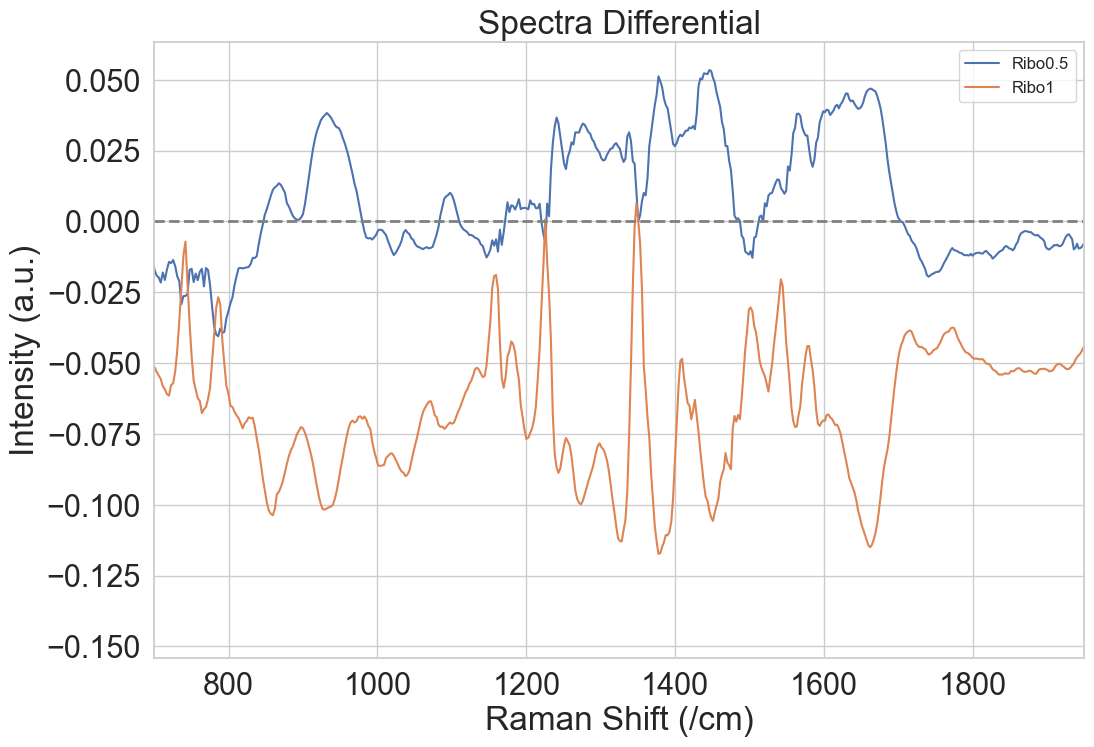

In [378]:
plt.figure(figsize = (12, 8))
sns.lineplot(
        data = drt,
        x = 'variable',
        y = 'value',
        hue = 'RiboConc',
        #hue_order=['pre','post1','post2', 'post3']
        #style='Trt'
        );
plt.title('Spectra Differential')
#plt.ylim(-.01, 1.1)
plt.xlim(700, 1950)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12)
plt.axhline(0, ls = '--', color = 'gray', lw=2)

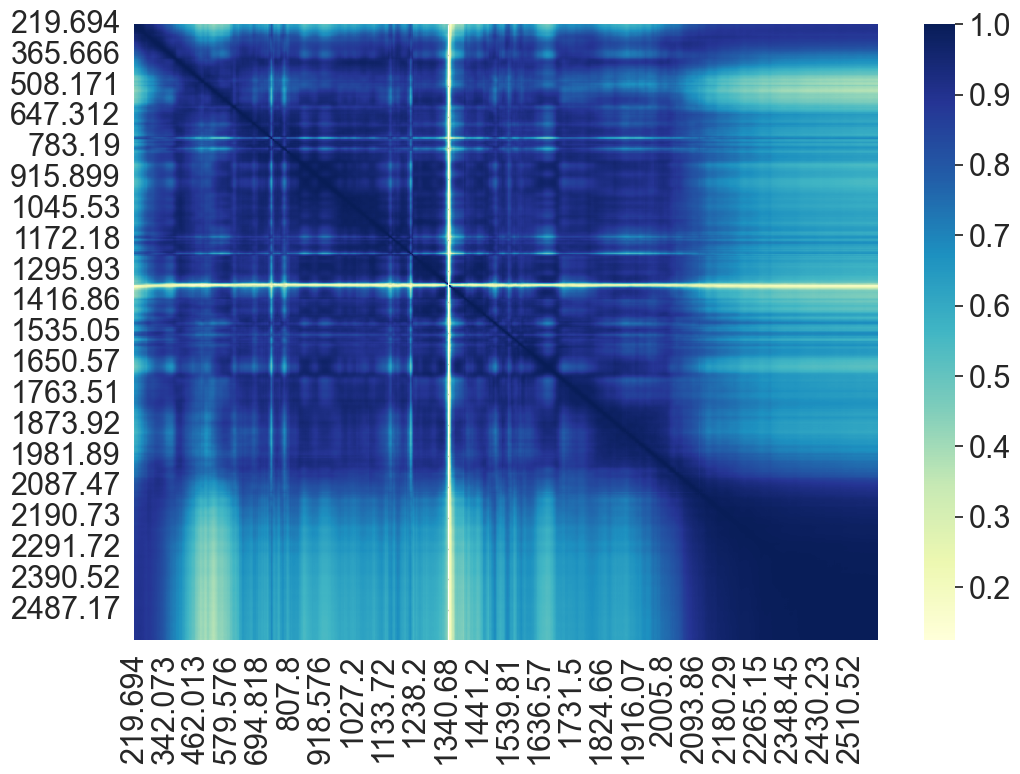

In [381]:
plt.figure(figsize = (12, 8))
sns.heatmap(dt_norm.corr(numeric_only=True),
             cmap='YlGnBu',
             #vmin=-1, vmax=1
             );

In [162]:
df_mag = dt.groupby('sample').mean().reset_index().melt(id_vars=['sample', 'spectra_num'])
df_mag[["variable", "value"]] = df_mag[["variable", "value"]].astype(float)

In [163]:
df_mag[df_mag['sample'] == 'Micetail_Ribo0.5_post']

sample  spectra_num  variable      value
0     Micetail_Ribo0.5_post          3.0   776.251 -35.687438
4     Micetail_Ribo0.5_post          3.0   777.424 -31.513148
8     Micetail_Ribo0.5_post          3.0   778.596 -35.736820
12    Micetail_Ribo0.5_post          3.0   779.769 -16.109186
16    Micetail_Ribo0.5_post          3.0   780.939   8.906660
...                     ...          ...       ...        ...
4076  Micetail_Ribo0.5_post          3.0  1877.880  12.054450
4080  Micetail_Ribo0.5_post          3.0  1878.870   9.352970
4084  Micetail_Ribo0.5_post          3.0  1879.870   7.459466
4088  Micetail_Ribo0.5_post          3.0  1880.860   6.406022
4092  Micetail_Ribo0.5_post          3.0  1881.860   6.057584

[1024 rows x 4 columns]

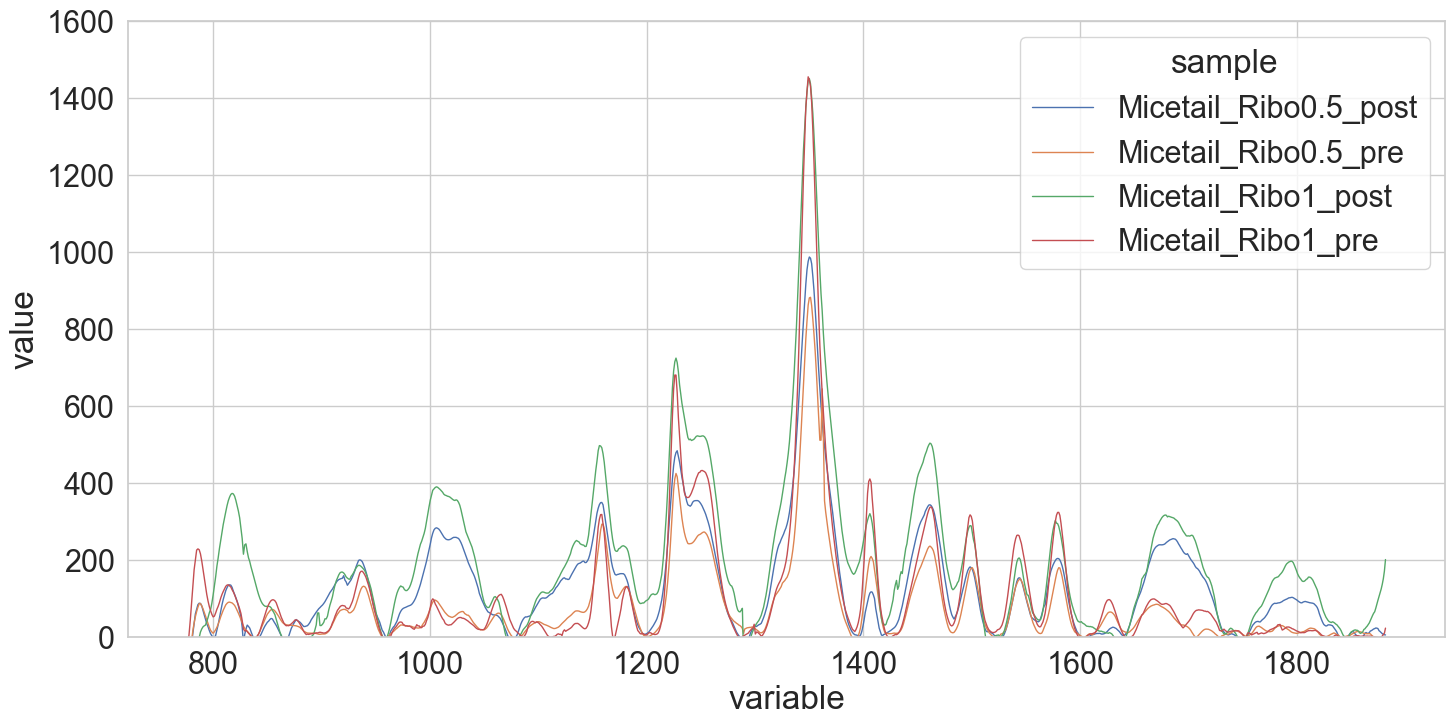

In [164]:
plt.figure(figsize = (17, 8))
sns.lineplot(
    data = df_mag,
    x = 'variable',
    y = 'value',
    hue = 'sample',
    lw = 1,

    );
plt.ylim(0, 1600);

In [165]:
df_mag[df_mag['sample'].str.contains('pre')]

sample  spectra_num  variable      value
1     Micetail_Ribo0.5_pre          3.0   776.251 -90.164672
3       Micetail_Ribo1_pre          3.0   776.251 -19.945447
5     Micetail_Ribo0.5_pre          3.0   777.424 -63.314144
7       Micetail_Ribo1_pre          3.0   777.424   6.797188
9     Micetail_Ribo0.5_pre          3.0   778.596 -35.733060
...                    ...          ...       ...        ...
4087    Micetail_Ribo1_pre          3.0  1879.870   7.235869
4089  Micetail_Ribo0.5_pre          3.0  1880.860 -31.766186
4091    Micetail_Ribo1_pre          3.0  1880.860  10.562074
4093  Micetail_Ribo0.5_pre          3.0  1881.860 -36.633198
4095    Micetail_Ribo1_pre          3.0  1881.860  23.659338

[2048 rows x 4 columns]

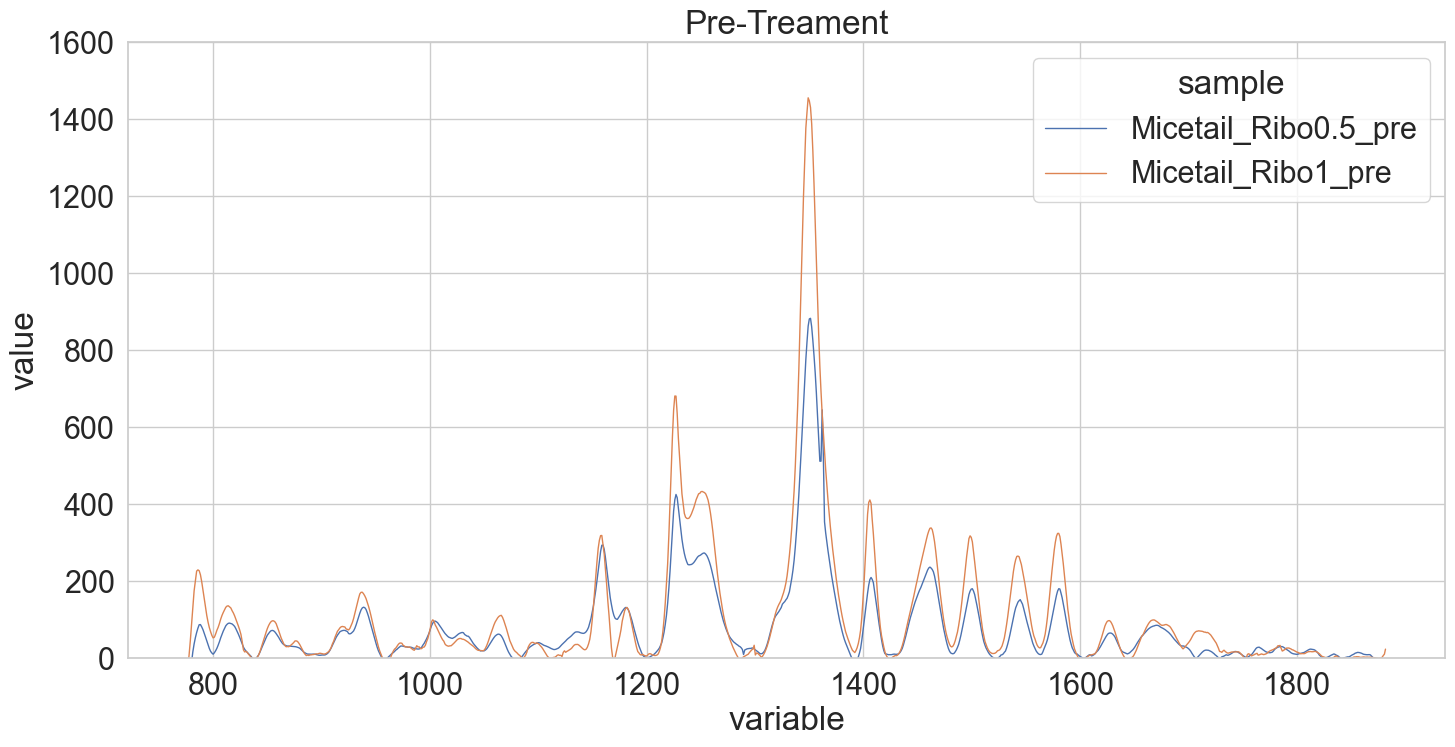

In [166]:
plt.figure(figsize = (17, 8))
sns.lineplot(
    data = df_mag[df_mag['sample'].str.contains('pre')],
    x = 'variable',
    y = 'value',
    hue = 'sample',
    lw = 1,

    );
plt.ylim(0, 1600);
plt.title('Pre-Treament');

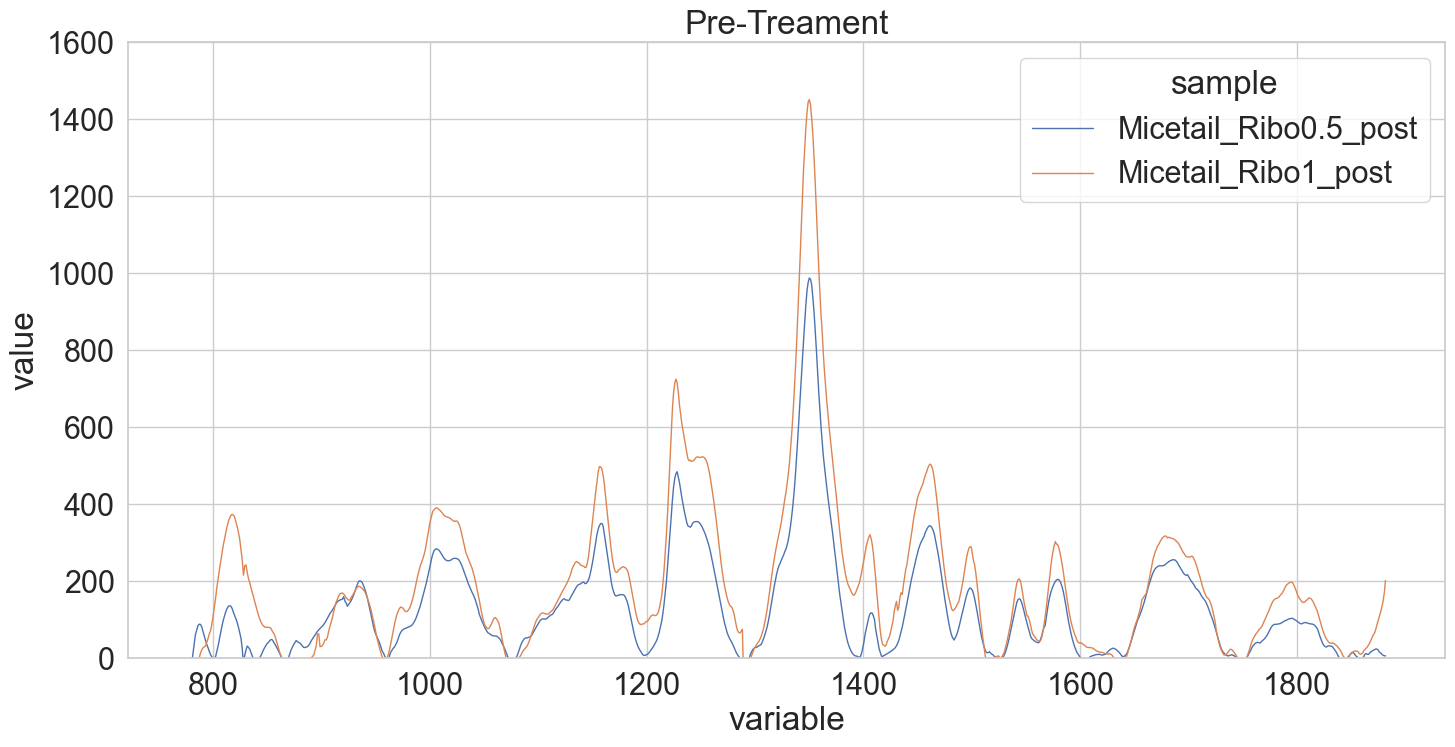

In [167]:
plt.figure(figsize = (17, 8))
sns.lineplot(
    data = df_mag[df_mag['sample'].str.contains('post')],
    x = 'variable',
    y = 'value',
    hue = 'sample',
    lw = 1,

    );
plt.ylim(0, 1600);
plt.title('Pre-Treament');

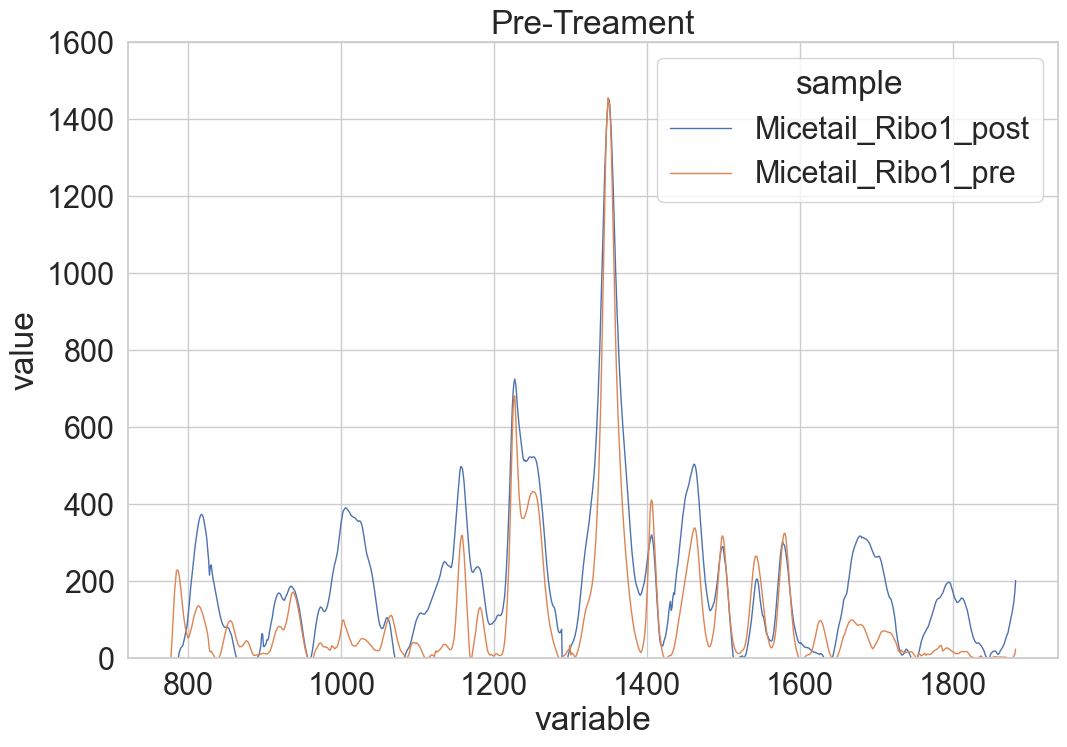

In [168]:
plt.figure(figsize = (12, 8))
sns.lineplot(
    data = df_mag[df_mag['sample'].str.contains('Ribo1')],
    x = 'variable',
    y = 'value',
    hue = 'sample',
    lw = 1,

    );
plt.ylim(0, 1600);
plt.title('Pre-Treament');

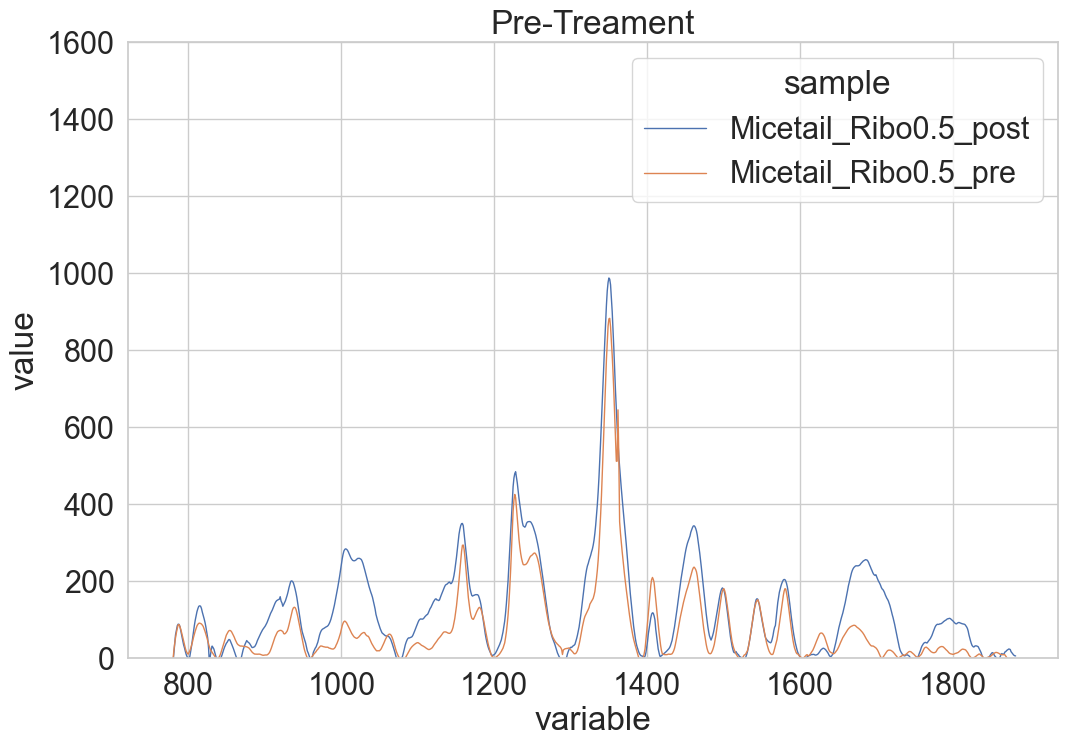

In [169]:
plt.figure(figsize = (12, 8))
sns.lineplot(
    data = df_mag[df_mag['sample'].str.contains('Ribo0.5')],
    x = 'variable',
    y = 'value',
    hue = 'sample',
    lw = 1,

    );
plt.ylim(0, 1600);
plt.title('Pre-Treament');

In [225]:
dtm = dt_norm.groupby(['sample']).mean().reset_index()
dtm

sample  spectra_num   776.251   777.424   778.596   779.769  \
0  Micetail_Ribo0.5_post         3.00 -0.034324 -0.031131 -0.035633 -0.016109   
1   Micetail_Ribo0.5_pre         3.00 -0.104190 -0.073590 -0.042074 -0.010500   
2    Micetail_Ribo1_post         2.75 -0.311310 -0.287669 -0.249781 -0.196015   
3     Micetail_Ribo1_pre         3.00 -0.008918  0.009264  0.035154  0.064712   

    780.939   782.111   783.283   784.455  ...   1872.89   1873.89   1874.89  \
0  0.009355  0.033810  0.062647  0.074306  ...  0.023956  0.023545  0.022389   
1  0.017917  0.041148  0.059775  0.075036  ... -0.006993 -0.009472 -0.012732   
2 -0.153095 -0.114427 -0.076990 -0.045150  ...  0.052423  0.060328  0.068227   
3  0.095543  0.124300  0.142170  0.159737  ...  0.000447  0.000179 -0.000013   

    1875.88   1876.88   1877.88   1878.87   1879.87   1880.86   1881.86  
0  0.017051  0.014773  0.012043  0.009328  0.007547  0.006585  0.006454  
1 -0.016297 -0.019122 -0.022716 -0.026824 -0.031097 -0.037068 -0.042781  
2  0.075509  0.082592  0.090911  0.100284  0.111598  0.126320  0.147335  
3 -0.000287  0.000113  0.000768  0.002075  0.005015  0.007192  0.015987  

[4 rows x 1026 columns]

In [226]:
spec_5 = (dtm[dtm['sample'].str.contains('0.5')].iloc[0, 2:]) - (dtm[dtm['sample'].str.contains('0.5')].iloc[1, 2:])

In [234]:
spec_1 = dtm[dtm['sample'].str.contains('1')].iloc[0, 2:] - (dtm[dtm['sample'].str.contains('1')].iloc[1, 2:])

In [235]:
dt_sub = pd.concat([pd.DataFrame(spec_5).T, pd.DataFrame(spec_1).T])#.insert(0, 'sample', ['Riboflavin_0.5', 'Riboflavin_1'])
dt_sub

776.251   777.424   778.596   779.769   780.939   782.111   783.283  \
0  0.069867  0.042459   0.00644 -0.005609 -0.008562 -0.007338  0.002872   
0 -0.302392 -0.296933 -0.284934 -0.260727 -0.248638 -0.238727  -0.21916   

    784.455   785.625   786.796  ...   1872.89   1873.89   1874.89   1875.88  \
0 -0.000731 -0.001304 -0.007458  ...   0.03095  0.033017  0.035121  0.033347   
0 -0.204887 -0.184925 -0.168324  ...  0.051976  0.060149  0.068241  0.075796   

    1876.88   1877.88   1878.87   1879.87   1880.86   1881.86  
0  0.033894  0.034759  0.036153  0.038644  0.043653  0.049236  
0  0.082479  0.090143  0.098209  0.106583  0.119128  0.131348  

[2 rows x 1024 columns]

In [236]:
dt_sub.insert(0, 'sample', ['Riboflavin_0.5', 'Riboflavin_1'])

In [237]:
dt_sub

sample   776.251   777.424   778.596   779.769   780.939   782.111  \
0  Riboflavin_0.5  0.069867  0.042459   0.00644 -0.005609 -0.008562 -0.007338   
0    Riboflavin_1 -0.302392 -0.296933 -0.284934 -0.260727 -0.248638 -0.238727   

    783.283   784.455   785.625  ...   1872.89   1873.89   1874.89   1875.88  \
0  0.002872 -0.000731 -0.001304  ...   0.03095  0.033017  0.035121  0.033347   
0  -0.21916 -0.204887 -0.184925  ...  0.051976  0.060149  0.068241  0.075796   

    1876.88   1877.88   1878.87   1879.87   1880.86   1881.86  
0  0.033894  0.034759  0.036153  0.038644  0.043653  0.049236  
0  0.082479  0.090143  0.098209  0.106583  0.119128  0.131348  

[2 rows x 1025 columns]

In [238]:
sub_m = dt_sub.melt(['sample'])
sub_m[['variable', 'value']] = sub_m[['variable', 'value']].astype(float)

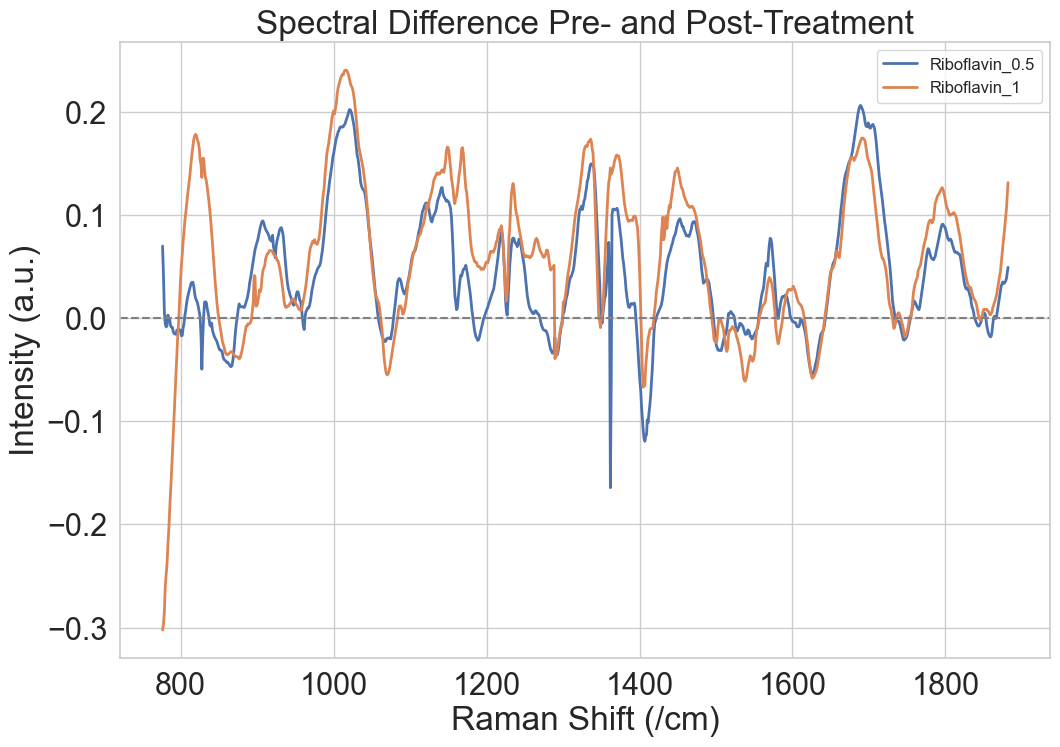

In [239]:
plt.figure(figsize = (12, 8))
sns.lineplot(
    data = sub_m,
    x = 'variable',
    y = 'value',
    hue = 'sample',
    lw = 2,

    );
plt.title('Spectral Difference Pre- and Post-Treatment')
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Raman Shift (/cm)')
plt.legend(fontsize = 12)
plt.axhline(0, color = 'gray', ls = '--')